# Combined Momentum Strategy: Forex + Commodities

Questo notebook implementa una strategia di momentum maturo top/ranking che combina forex e commodities.

## Strategia:
- **Dati**: Combina forex e commodities con scaling per equalizzare le magnitudini
- **Segnali**: Ogni venerdì ranking degli asset per momentum
- **Posizioni**: Long sui migliori 5, Short sui peggiori 5
- **Holding Period**: Da venerdì a venerdì (5 giorni)
- **Anti Look-ahead**: Tutti i calcoli sono basati solo su dati storici

## Struttura del Notebook:
1. Import e configurazione
2. Caricamento e analisi dati
3. Calcolo fattori di scaling volatilità
4. Applicazione scaling ai dati
5. Calcolo momentum scores
6. Generazione segnali del venerdì
7. Esecuzione backtest strategia
8. Analisi performance e visualizzazioni
9. Analisi contributi asset
10. Generazione segnali correnti

## 1. Import Libraries e Configurazione

Importiamo le librerie necessarie e configuriamo l'ambiente di lavoro.

In [1]:
# Import delle librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import del nostro modulo personalizzato
import sys
sys.path.append('../')
from core.combined_momentum import CombinedMomentumStrategy

# Configurazione plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Librerie importate con successo")

✅ Librerie importate con successo


## 2. Caricamento e Analisi Dati

Inizializziamo la strategia e carichiamo i dati forex e commodities.

In [2]:
# Inizializziamo la strategia
strategy = CombinedMomentumStrategy(data_path="../data")

# Carichiamo i dati
forex_data, commodity_data = strategy.load_data()

print(f"\n📊 Dati Forex: {forex_data.shape}")
print(f"📊 Dati Commodities: {commodity_data.shape}")
print(f"\n📅 Range temporale Forex: {forex_data.index.min().date()} - {forex_data.index.max().date()}")
print(f"📅 Range temporale Commodities: {commodity_data.index.min().date()} - {commodity_data.index.max().date()}")

✅ Loaded forex data: (6667, 154)
✅ Loaded commodity data: (6452, 189)

📊 Dati Forex: (6667, 154)
📊 Dati Commodities: (6452, 189)

📅 Range temporale Forex: 2000-01-03 - 2025-08-03
📅 Range temporale Commodities: 2000-01-03 - 2025-08-04


In [3]:
# Analizziamo le colonne forex e commodities
forex_assets = [col.replace('_Close', '') for col in forex_data.columns if col.endswith('_Close')]
commodity_assets = [col.replace('_Close', '') for col in commodity_data.columns if col.endswith('_Close')]

print(f"📈 Asset Forex disponibili ({len(forex_assets)}):")
for i, asset in enumerate(forex_assets):
    print(f"   {i+1:2d}. {asset}")

print(f"\n🥇 Asset Commodities disponibili ({len(commodity_assets)}):")
for i, asset in enumerate(commodity_assets):
    print(f"   {i+1:2d}. {asset}")

print(f"\n📊 Totale asset: {len(forex_assets) + len(commodity_assets)}")

📈 Asset Forex disponibili (22):
    1. EURUSD
    2. GBPUSD
    3. USDJPY
    4. USDCHF
    5. AUDUSD
    6. USDCAD
    7. NZDUSD
    8. EURGBP
    9. EURJPY
   10. GBPJPY
   11. CHFJPY
   12. EURCHF
   13. AUDJPY
   14. CADJPY
   15. NZDJPY
   16. GBPCHF
   17. AUDCAD
   18. AUDCHF
   19. CADCHF
   20. EURCAD
   21. EURAUD
   22. GBPCAD

🥇 Asset Commodities disponibili (27):
    1. GOLD
    2. SILVER
    3. PLATINUM
    4. PALLADIUM
    5. COPPER
    6. CRUDE_WTI
    7. CRUDE_BRENT
    8. NATGAS
    9. HEATING_OIL
   10. GASOLINE
   11. CORN
   12. WHEAT
   13. SOYBEANS
   14. SOYMEAL
   15. SOYOIL
   16. OATS
   17. ROUGH_RICE
   18. COFFEE
   19. SUGAR
   20. COTTON
   21. ORANGE_JUICE
   22. COCOA
   23. LIVE_CATTLE
   24. LEAN_HOGS
   25. FEEDER_CATTLE
   26. LUMBER
   27. RUSSELL_2000_MINI

📊 Totale asset: 49


✅ Combined close prices: (13119, 49)
📅 Date range: 2000-01-03 to 2025-08-04

📊 Dati combinati: (13119, 49)
📅 Range: 2000-01-03 - 2025-08-04

📈 Disponibilità dati per asset (primi 10):
USDJPY        13119
EURGBP        13119
COFFEE        13118
OATS          13118
ROUGH_RICE    13118
COCOA         13118
COTTON        13118
PLATINUM      13116
PALLADIUM     13116
SUGAR         13036
dtype: int64


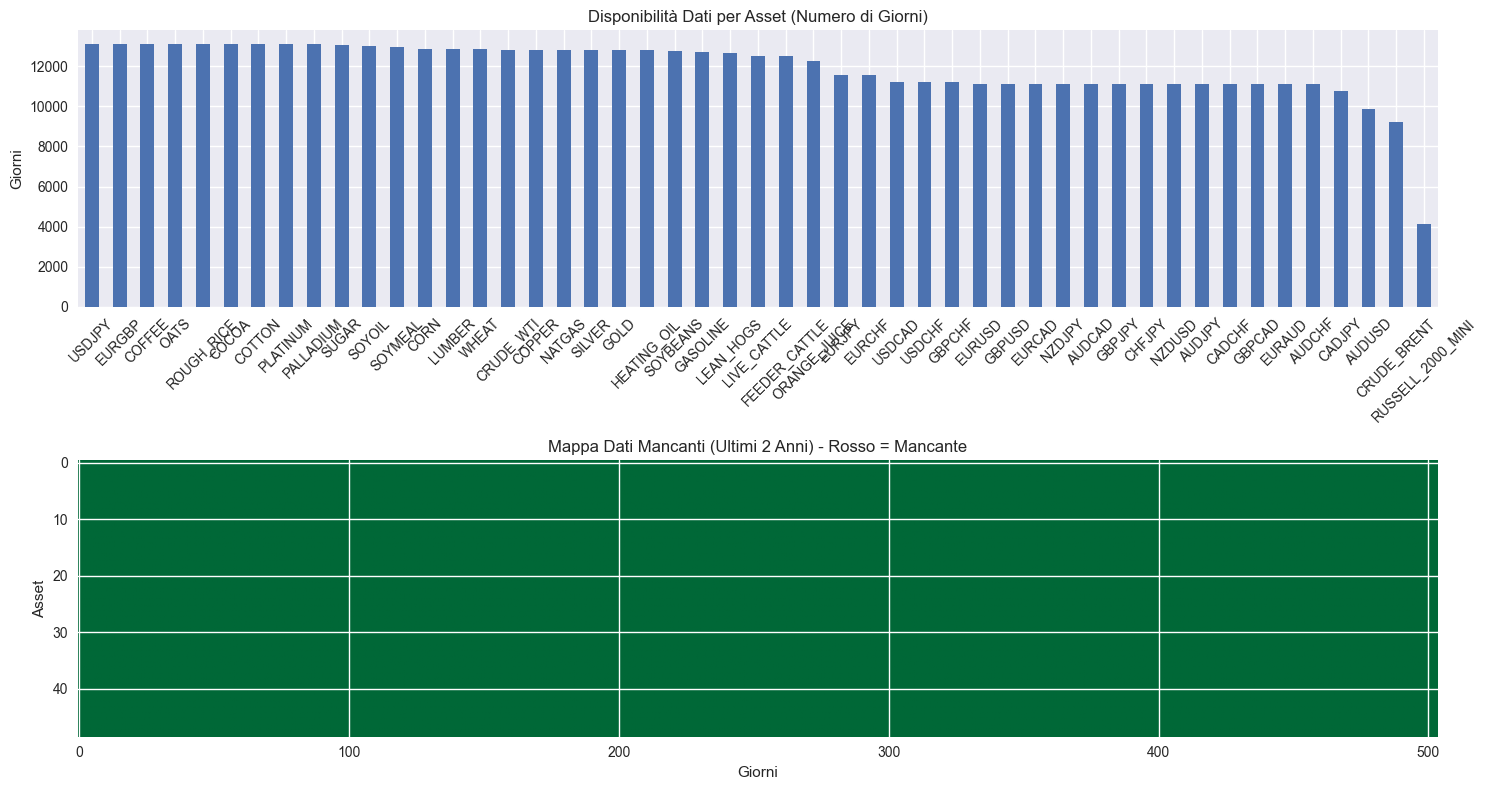

In [4]:
# Estraiamo i prezzi di chiusura combinati
combined_data = strategy.extract_close_prices()

print(f"\n📊 Dati combinati: {combined_data.shape}")
print(f"📅 Range: {combined_data.index.min().date()} - {combined_data.index.max().date()}")

# Visualizziamo la disponibilità dei dati
data_availability = combined_data.notna().sum().sort_values(ascending=False)
print(f"\n📈 Disponibilità dati per asset (primi 10):")
print(data_availability.head(10))

# Plot della disponibilità dei dati
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
data_availability.plot(kind='bar')
plt.title('Disponibilità Dati per Asset (Numero di Giorni)')
plt.xticks(rotation=45)
plt.ylabel('Giorni')

# Heatmap della presenza dati negli ultimi anni
plt.subplot(2, 1, 2)
recent_data = combined_data.tail(252 * 2)  # Ultimi 2 anni
missing_data = recent_data.isna().astype(int)
plt.imshow(missing_data.T, aspect='auto', cmap='RdYlGn_r')
plt.title('Mappa Dati Mancanti (Ultimi 2 Anni) - Rosso = Mancante')
plt.ylabel('Asset')
plt.xlabel('Giorni')

plt.tight_layout()
plt.show()

## 3. Calcolo Fattori di Scaling Volatilità

Calcoliamo i fattori di scaling per normalizzare le commodities alla stessa magnitudine del forex.

📊 Target volatility: 0.1190
📊 Scaling factors range: 0.1188 to 2.8346

📊 Fattori di Scaling (primi 10):
     Asset  Scaling_Factor
7   EURGBP        2.834600
5   USDCAD        2.759623
11  EURCHF        2.623851
21  GBPCAD        2.488148
10  CHFJPY        2.240447
19  EURCAD        2.154278
1   GBPUSD        2.138443
8   EURJPY        2.012555
15  GBPCHF        1.884893
16  AUDCAD        1.862276

📈 Fattori Forex - Media: 1.868, Std: 0.491
🥇 Fattori Commodities - Media: 0.604, Std: 0.265


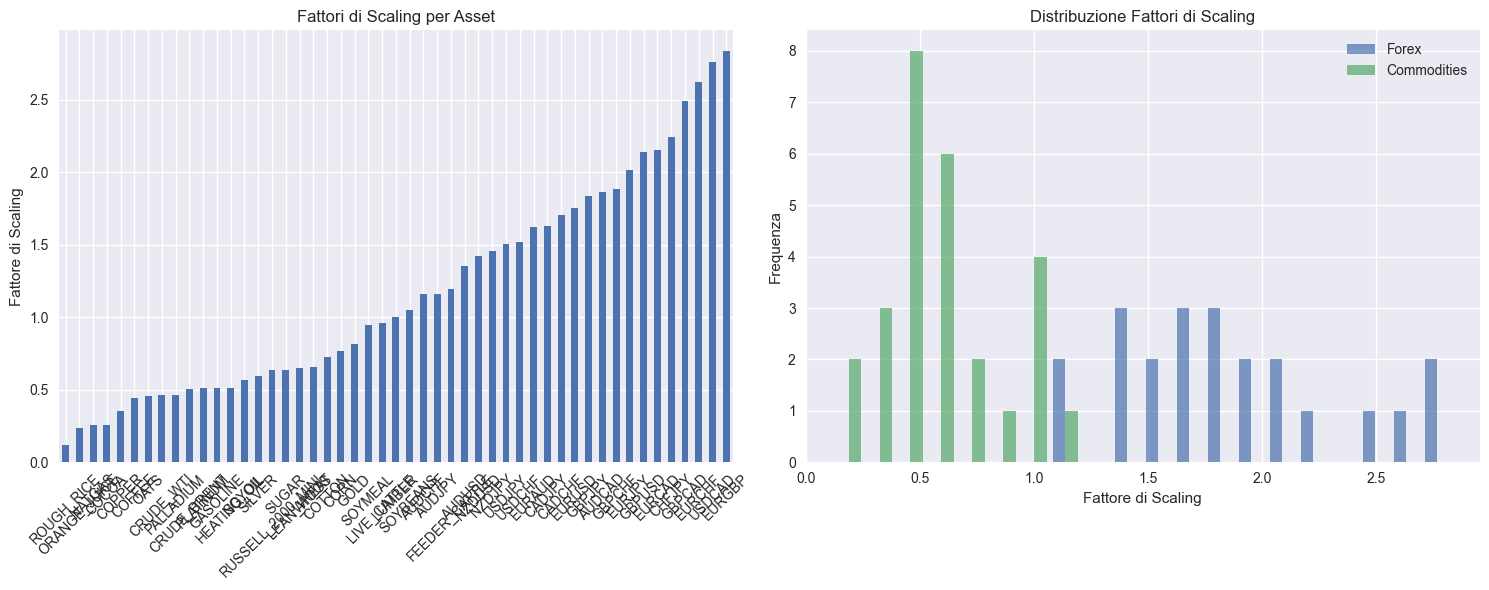

In [5]:
# Calcoliamo la volatilità e i fattori di scaling
scaling_factors = strategy.calculate_volatility_scaling(lookback_days=252)

# Analizziamo i fattori di scaling
print(f"\n📊 Fattori di Scaling (primi 10):")
scaling_df = pd.DataFrame({
    'Asset': scaling_factors.index,
    'Scaling_Factor': scaling_factors.values
}).sort_values('Scaling_Factor', ascending=False)

print(scaling_df.head(10))

# Identifichiamo forex vs commodities
forex_scaling = scaling_factors[forex_assets].dropna()
commodity_scaling = scaling_factors[commodity_assets].dropna()

print(f"\n📈 Fattori Forex - Media: {forex_scaling.mean():.3f}, Std: {forex_scaling.std():.3f}")
print(f"🥇 Fattori Commodities - Media: {commodity_scaling.mean():.3f}, Std: {commodity_scaling.std():.3f}")

# Plot dei fattori di scaling
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
scaling_factors.sort_values().plot(kind='bar')
plt.title('Fattori di Scaling per Asset')
plt.xticks(rotation=45)
plt.ylabel('Fattore di Scaling')

plt.subplot(1, 2, 2)
plt.hist([forex_scaling.values, commodity_scaling.values], 
         bins=20, alpha=0.7, label=['Forex', 'Commodities'])
plt.title('Distribuzione Fattori di Scaling')
plt.xlabel('Fattore di Scaling')
plt.ylabel('Frequenza')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Applicazione Scaling ai Dati

Applichiamo i fattori di scaling per normalizzare tutti gli asset.

✅ Applied scaling to 49 assets

📊 Dati scalati: (4133, 49)

📊 Confronto Volatilità (annualizzata):
   Originale - Media: 0.675, Range: 0.037 - 25.112
   Scalata - Media: 0.186, Range: 0.061 - 2.984


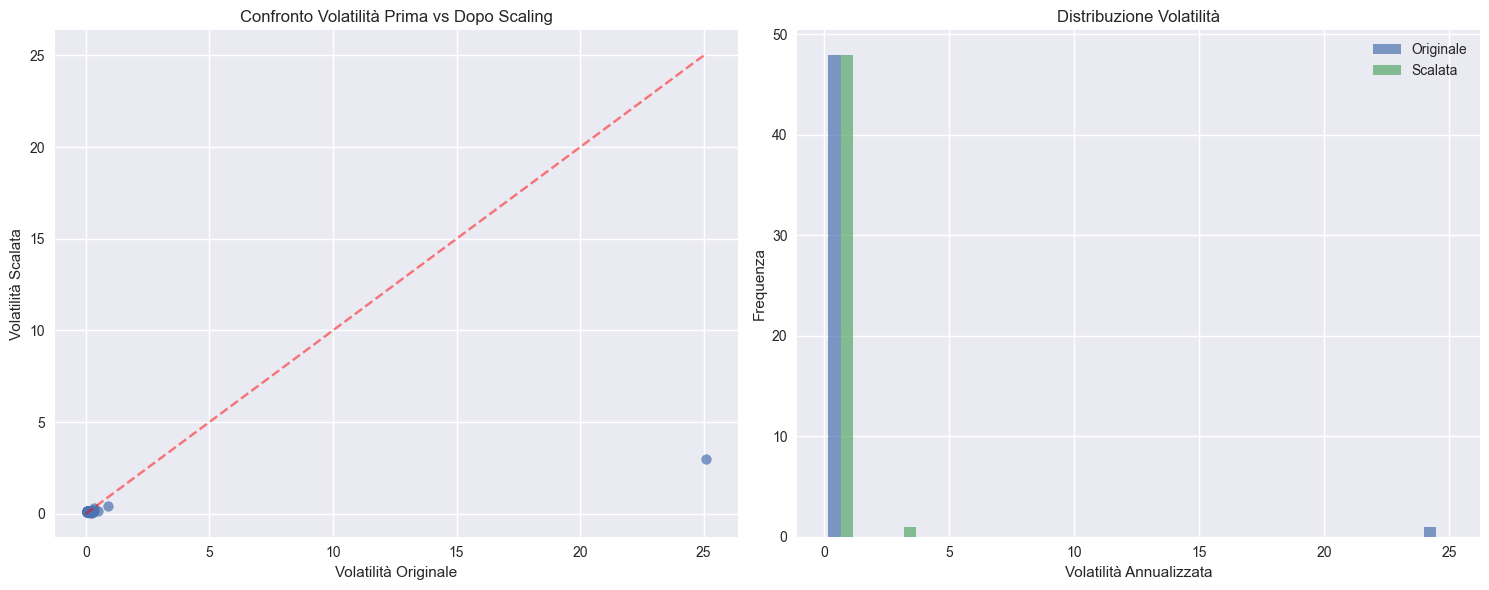

In [6]:
# Applichiamo lo scaling
scaled_data = strategy.apply_scaling(scaling_factors)

print(f"\n📊 Dati scalati: {scaled_data.shape}")

# Confrontiamo la volatilità prima e dopo lo scaling
original_returns = combined_data.pct_change().dropna()
scaled_returns = scaled_data.pct_change().dropna()

original_vol = original_returns.std() * np.sqrt(252)
scaled_vol = scaled_returns.std() * np.sqrt(252)

vol_comparison = pd.DataFrame({
    'Original_Vol': original_vol,
    'Scaled_Vol': scaled_vol
}).dropna()

print(f"\n📊 Confronto Volatilità (annualizzata):")
print(f"   Originale - Media: {vol_comparison['Original_Vol'].mean():.3f}, Range: {vol_comparison['Original_Vol'].min():.3f} - {vol_comparison['Original_Vol'].max():.3f}")
print(f"   Scalata - Media: {vol_comparison['Scaled_Vol'].mean():.3f}, Range: {vol_comparison['Scaled_Vol'].min():.3f} - {vol_comparison['Scaled_Vol'].max():.3f}")

# Plot confronto volatilità
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(vol_comparison['Original_Vol'], vol_comparison['Scaled_Vol'], alpha=0.7)
plt.plot([0, vol_comparison['Original_Vol'].max()], [0, vol_comparison['Original_Vol'].max()], 'r--', alpha=0.5)
plt.xlabel('Volatilità Originale')
plt.ylabel('Volatilità Scalata')
plt.title('Confronto Volatilità Prima vs Dopo Scaling')

plt.subplot(1, 2, 2)
plt.hist([vol_comparison['Original_Vol'], vol_comparison['Scaled_Vol']], 
         bins=20, alpha=0.7, label=['Originale', 'Scalata'])
plt.xlabel('Volatilità Annualizzata')
plt.ylabel('Frequenza')
plt.title('Distribuzione Volatilità')
plt.legend()

plt.tight_layout()
plt.show()

## 5. Calcolo Momentum Scores

Calcoliamo i punteggi di momentum per tutti gli asset usando un lookback di 21 giorni.

✅ Calculated momentum scores with 5-day lookback
📊 Momentum scores shape: (4128, 49)

📊 Momentum Scores: (4128, 49)
📅 Range: 2017-07-13 - 2025-08-04

📊 Statistiche Momentum (ultimo anno, primi 5 asset):
            mean       std       min       max
EURUSD  0.004078  0.016841 -0.048589  0.064807
GBPUSD  0.002972  0.017429 -0.057338  0.058772
USDJPY -0.001362  0.015899 -0.043398  0.046729
USDCHF -0.003522  0.016019 -0.070009  0.039079
AUDUSD  0.001224  0.016500 -0.078554  0.078994


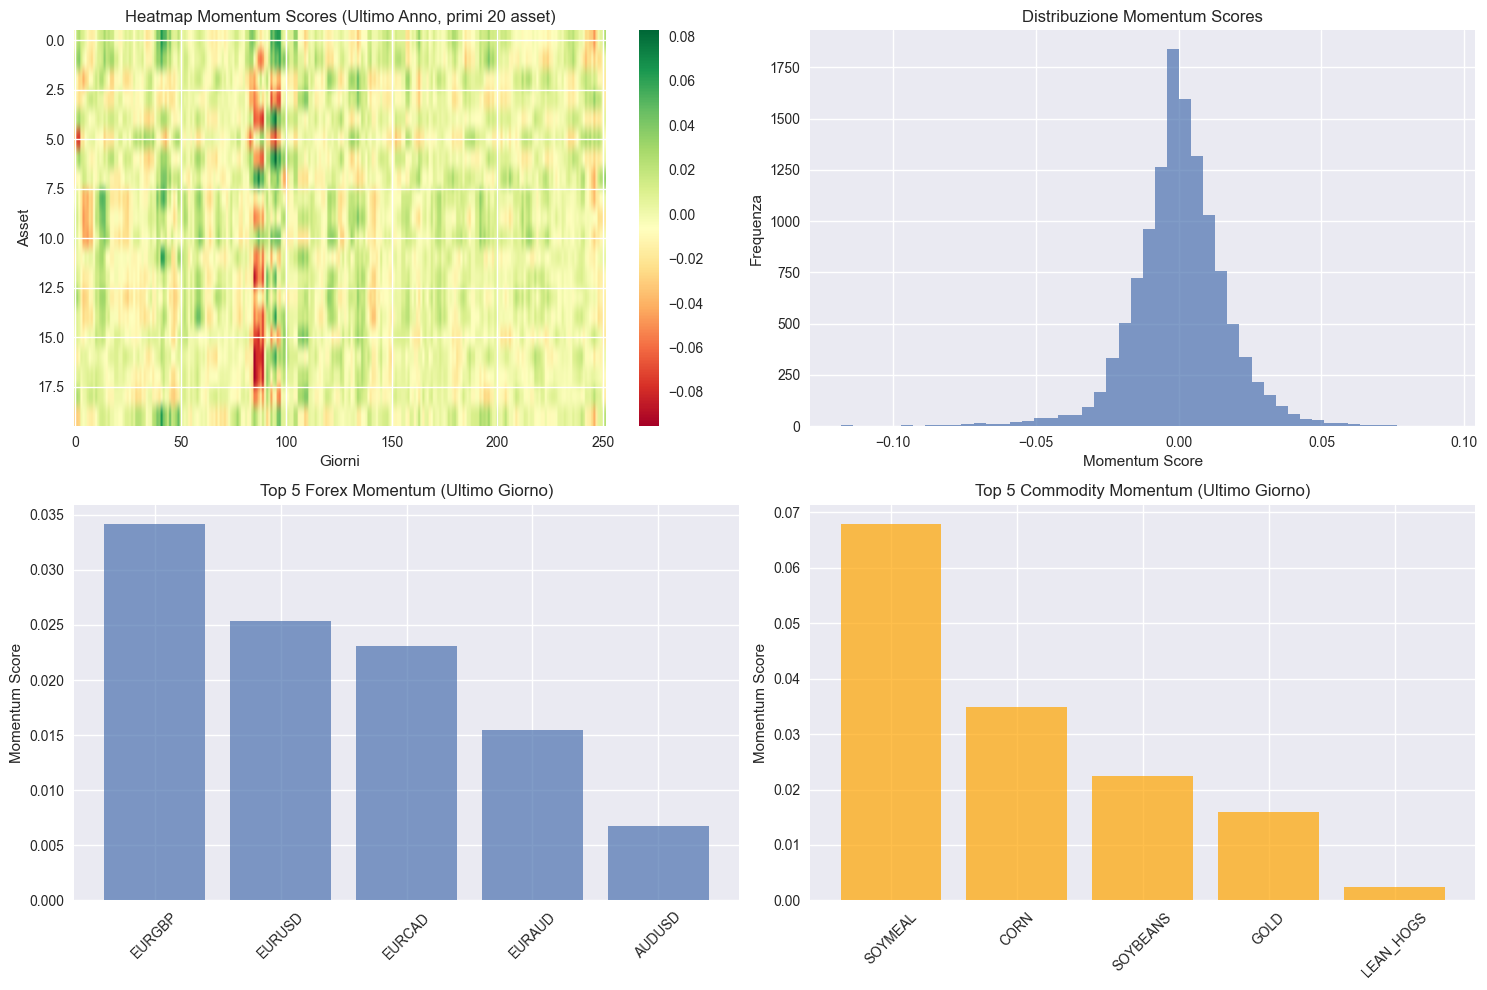

In [7]:
# Calcoliamo i momentum scores
momentum_lookback = 5  # 3 settimane
momentum_scores = strategy.calculate_momentum_scores(lookback_days=momentum_lookback)

print(f"\n📊 Momentum Scores: {momentum_scores.shape}")
print(f"📅 Range: {momentum_scores.index.min().date()} - {momentum_scores.index.max().date()}")

# Analizziamo la distribuzione dei momentum scores
recent_momentum = momentum_scores.tail(252)  # Ultimo anno
momentum_stats = recent_momentum.describe()

print(f"\n📊 Statistiche Momentum (ultimo anno, primi 5 asset):")
print(momentum_stats.loc[['mean', 'std', 'min', 'max']].T.head(5))

# Plot distribuzione momentum
plt.figure(figsize=(15, 10))

# Heatmap momentum scores
plt.subplot(2, 2, 1)
recent_momentum_clean = recent_momentum.dropna(axis=1, how='all')
if len(recent_momentum_clean.columns) > 0:
    plt.imshow(recent_momentum_clean.iloc[:, :min(20, len(recent_momentum_clean.columns))].T, 
               aspect='auto', cmap='RdYlGn')
    plt.title('Heatmap Momentum Scores (Ultimo Anno, primi 20 asset)')
    plt.ylabel('Asset')
    plt.xlabel('Giorni')
    plt.colorbar()

# Distribuzione momentum
plt.subplot(2, 2, 2)
all_momentum = recent_momentum.values.flatten()
all_momentum = all_momentum[~np.isnan(all_momentum)]
plt.hist(all_momentum, bins=50, alpha=0.7)
plt.title('Distribuzione Momentum Scores')
plt.xlabel('Momentum Score')
plt.ylabel('Frequenza')

# Top momentum per categoria
plt.subplot(2, 2, 3)
latest_momentum = momentum_scores.iloc[-1].dropna().sort_values(ascending=False)
if len(latest_momentum) > 0:
    forex_momentum = latest_momentum[latest_momentum.index.isin(forex_assets)].head(5)
    if len(forex_momentum) > 0:
        x_pos = np.arange(len(forex_momentum))
        plt.bar(x_pos, forex_momentum.values, alpha=0.7, label='Top Forex')
        plt.xticks(x_pos, forex_momentum.index, rotation=45)
    plt.title('Top 5 Forex Momentum (Ultimo Giorno)')
    plt.ylabel('Momentum Score')

plt.subplot(2, 2, 4)
if len(latest_momentum) > 0:
    commodity_momentum = latest_momentum[latest_momentum.index.isin(commodity_assets)].head(5)
    if len(commodity_momentum) > 0:
        x_pos = np.arange(len(commodity_momentum))
        plt.bar(x_pos, commodity_momentum.values, alpha=0.7, color='orange')
        plt.xticks(x_pos, commodity_momentum.index, rotation=45)
    plt.title('Top 5 Commodity Momentum (Ultimo Giorno)')
    plt.ylabel('Momentum Score')

plt.tight_layout()
plt.show()

## 6. Generazione Segnali del Venerdì

Generiamo i segnali di trading ogni venerdì basati sul ranking del momentum.

✅ Generated signals for 582 Fridays
📊 Signal summary:
   Long positions: 2910
   Short positions: 2910

📊 Segnali generati: (582, 49)
📅 Numero di venerdì: 582

📊 Riepilogo Segnali (statistiche):
       Long_Positions  Short_Positions  Total_Positions
count           582.0            582.0            582.0
mean              5.0              5.0             10.0
std               0.0              0.0              0.0
min               5.0              5.0             10.0
25%               5.0              5.0             10.0
50%               5.0              5.0             10.0
75%               5.0              5.0             10.0
max               5.0              5.0             10.0

📈 Asset più spesso Long (top 10):
LUMBER           157
SOYMEAL          121
USDCAD           107
LEAN_HOGS        105
COTTON            98
EURGBP            97
WHEAT             95
FEEDER_CATTLE     95
GASOLINE          92
SOYBEANS          90
dtype: int64

📉 Asset più spesso Short (top 10):
LUMBER 

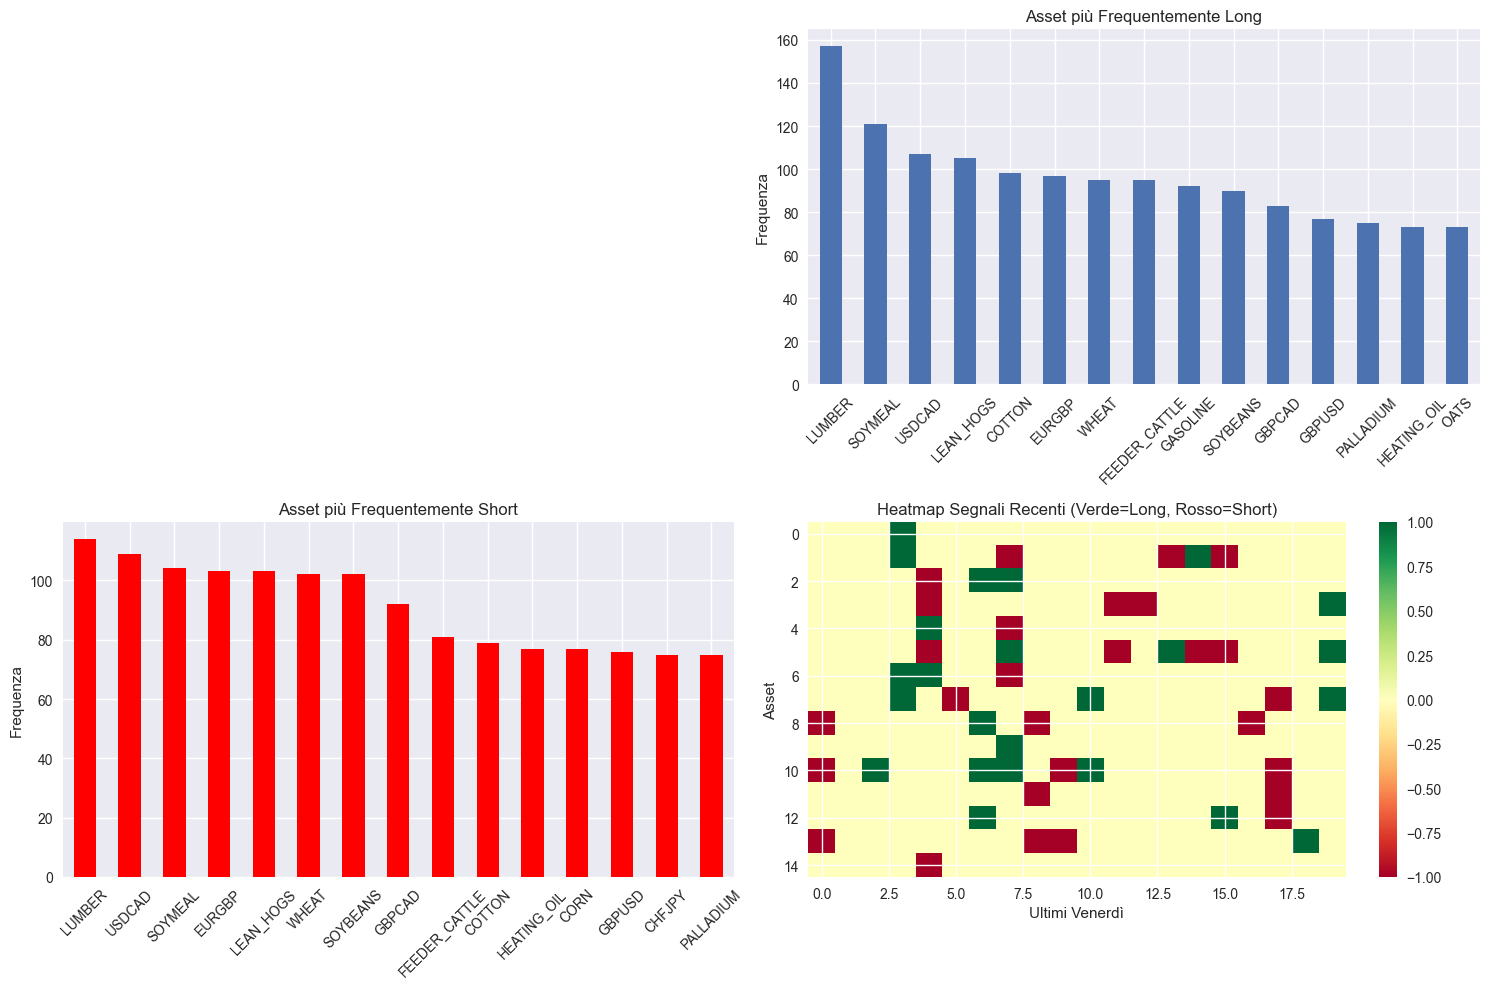

In [8]:
# Generiamo i segnali ogni venerdì
top_n = 5
bottom_n = 5
signals = strategy.generate_friday_signals(momentum_scores, top_n=top_n, bottom_n=bottom_n)

print(f"\n📊 Segnali generati: {signals.shape}")
print(f"📅 Numero di venerdì: {len(signals)}")

# Analizziamo i segnali
signal_summary = pd.DataFrame({
    'Long_Positions': (signals == 1).sum(axis=1),
    'Short_Positions': (signals == -1).sum(axis=1),
    'Total_Positions': (signals != 0).sum(axis=1)
})

print(f"\n📊 Riepilogo Segnali (statistiche):")
print(signal_summary.describe())

# Asset più frequentemente selezionati
long_frequency = (signals == 1).sum().sort_values(ascending=False)
short_frequency = (signals == -1).sum().sort_values(ascending=False)

print(f"\n📈 Asset più spesso Long (top 10):")
print(long_frequency.head(10))

print(f"\n📉 Asset più spesso Short (top 10):")
print(short_frequency.head(10))

# Plot analisi segnali
plt.figure(figsize=(15, 10))



# Frequenza asset long
plt.subplot(2, 2, 2)
if len(long_frequency) > 0:
    long_frequency.head(15).plot(kind='bar')
    plt.title('Asset più Frequentemente Long')
    plt.xticks(rotation=45)
    plt.ylabel('Frequenza')

# Frequenza asset short
plt.subplot(2, 2, 3)
if len(short_frequency) > 0:
    short_frequency.head(15).plot(kind='bar', color='red')
    plt.title('Asset più Frequentemente Short')
    plt.xticks(rotation=45)
    plt.ylabel('Frequenza')

# Heatmap segnali recenti
plt.subplot(2, 2, 4)
recent_signals = signals.tail(20)  # Ultimi 20 venerdì
if len(recent_signals) > 0:
    active_assets = recent_signals.columns[(recent_signals != 0).any()]
    if len(active_assets) > 0:
        # Selezioniamo solo i primi 15 asset attivi per leggibilità
        selected_assets = active_assets[:min(15, len(active_assets))]
        plt.imshow(recent_signals[selected_assets].T, aspect='auto', cmap='RdYlGn')
        plt.title('Heatmap Segnali Recenti (Verde=Long, Rosso=Short)')
        plt.ylabel('Asset')
        plt.xlabel('Ultimi Venerdì')
        plt.colorbar()

plt.tight_layout()
plt.show()

## 7. Esecuzione Backtest Strategia

Eseguiamo il backtest completo della strategia di momentum.

In [9]:
# Eseguiamo il backtest
backtest_results = strategy.backtest_strategy(signals, holding_period_days=5)

# Estraiamo i risultati principali
daily_returns = backtest_results['daily_returns']
cumulative_returns = backtest_results['cumulative_returns']
positions = backtest_results['positions']

print(f"\n📊 Performance della Strategia:")
print(f"   📈 Return Totale: {backtest_results['total_return']:.2%}")
print(f"   📈 Return Annualizzato: {backtest_results['annualized_return']:.2%}")
print(f"   📊 Volatilità: {backtest_results['volatility']:.2%}")
print(f"   ⚡ Sharpe Ratio: {backtest_results['sharpe_ratio']:.3f}")
print(f"   📉 Max Drawdown: {backtest_results['max_drawdown']:.2%}")

# Statistiche aggiuntive
win_rate = (daily_returns > 0).mean()
avg_win = daily_returns[daily_returns > 0].mean()
avg_loss = daily_returns[daily_returns < 0].mean()
profit_factor = -avg_win / avg_loss if avg_loss != 0 else np.inf

print(f"\n📊 Statistiche Aggiuntive:")
print(f"   🎯 Win Rate: {win_rate:.2%}")
print(f"   📈 Guadagno Medio: {avg_win:.4f} ({avg_win*252:.2%} annuo)")
print(f"   📉 Perdita Media: {avg_loss:.4f} ({avg_loss*252:.2%} annuo)")
print(f"   💰 Profit Factor: {profit_factor:.2f}")
print(f"   📅 Giorni di Trading: {len(daily_returns)}")
print(f"   📅 Anni di Dati: {len(daily_returns) / 252:.1f}")


📊 Backtest Results:
   Total Return: -96.39%
   Annualized Return: -18.33%
   Volatility: 63.88%
   Sharpe Ratio: -0.287
   Max Drawdown: -96.80%

📊 Performance della Strategia:
   📈 Return Totale: -96.39%
   📈 Return Annualizzato: -18.33%
   📊 Volatilità: 63.88%
   ⚡ Sharpe Ratio: -0.287
   📉 Max Drawdown: -96.80%

📊 Statistiche Aggiuntive:
   🎯 Win Rate: 29.43%
   📈 Guadagno Medio: 0.0294 (741.19% annuo)
   📉 Perdita Media: -0.0283 (-714.15% annuo)
   💰 Profit Factor: 1.04
   📅 Giorni di Trading: 4132
   📅 Anni di Dati: 16.4


## 8. Analisi Performance e Visualizzazioni

Creiamo grafici dettagliati per analizzare la performance della strategia.

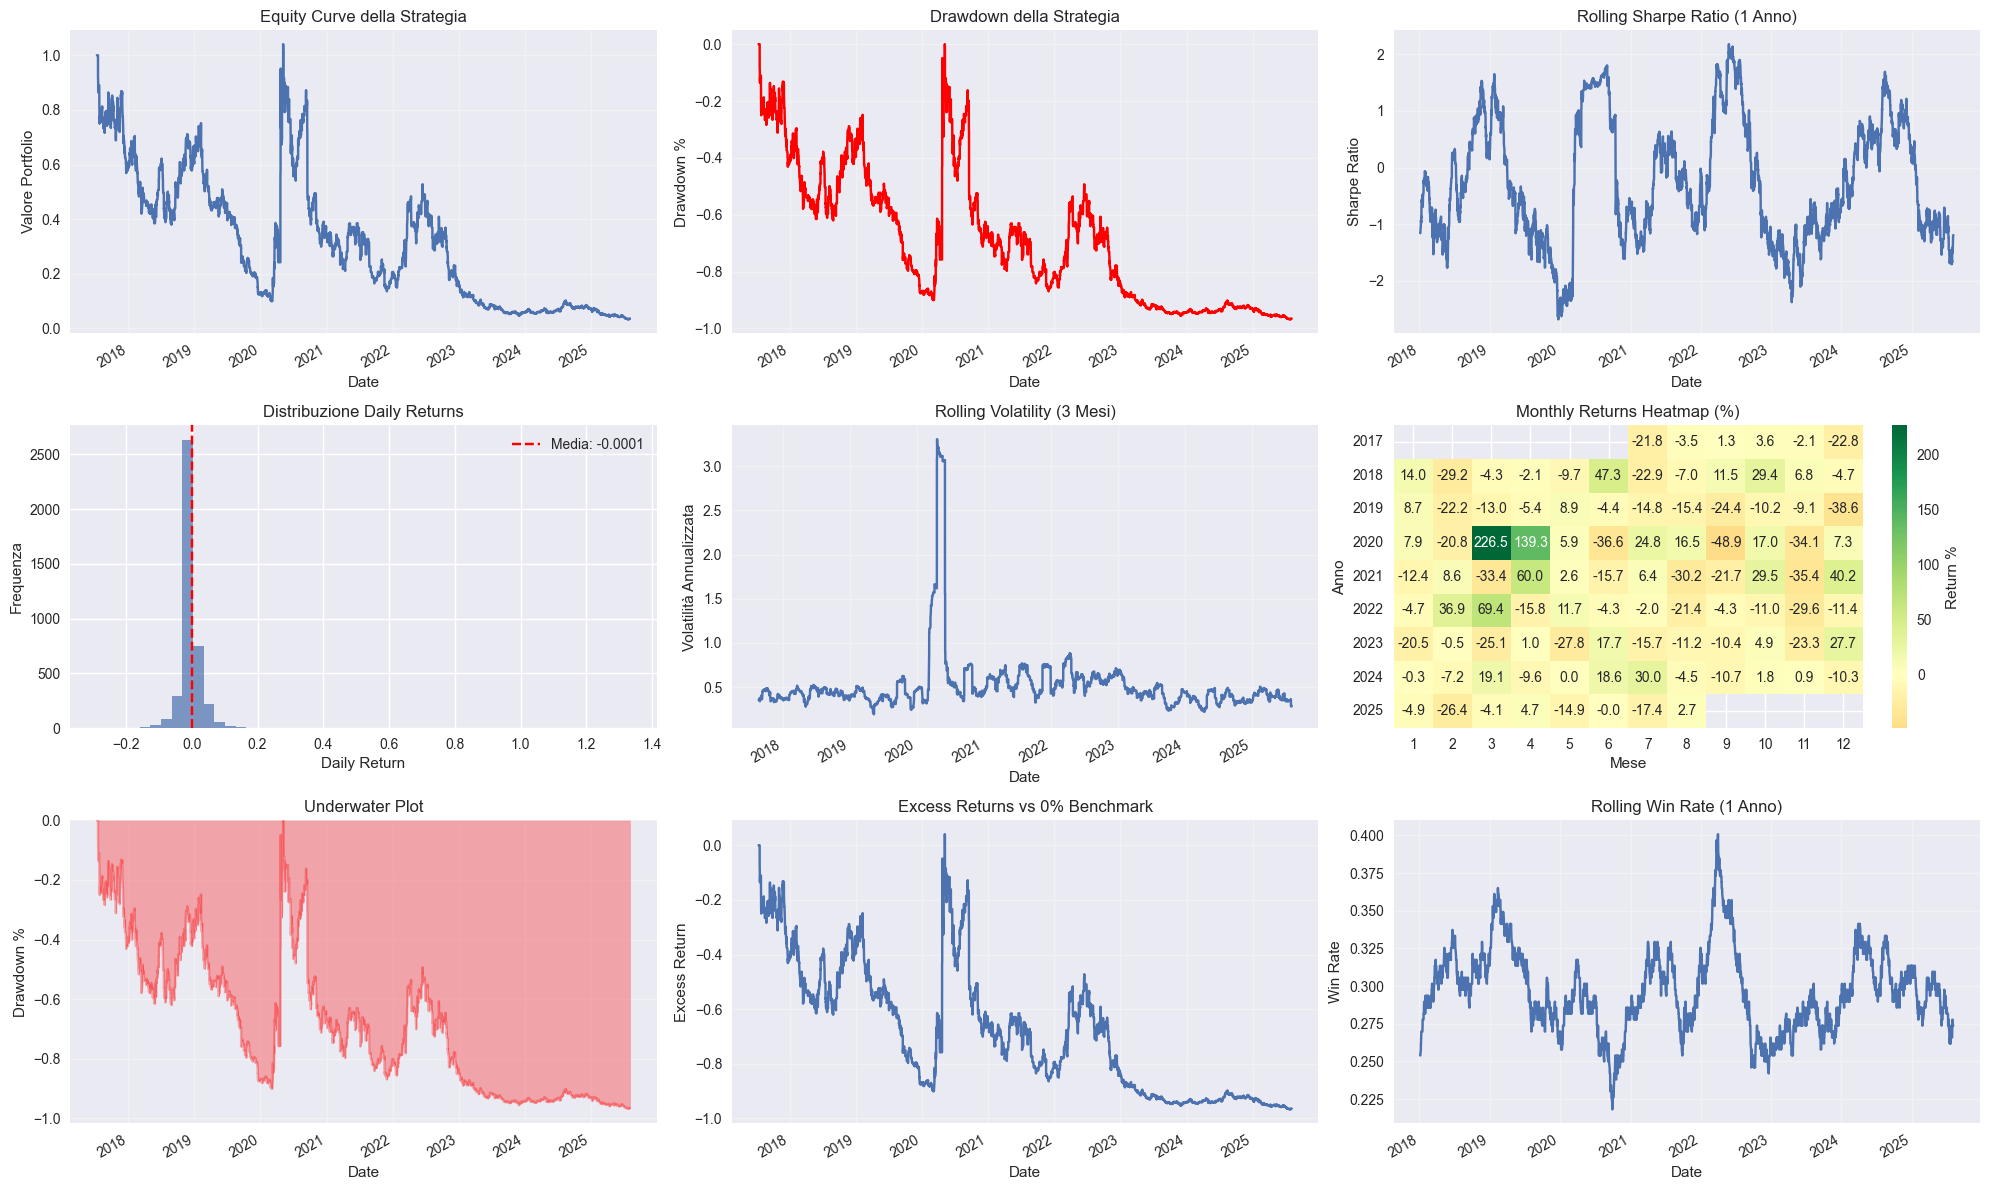

In [10]:
# Plot performance completa
plt.figure(figsize=(20, 12))

# 1. Equity Curve
plt.subplot(3, 3, 1)
cumulative_returns.plot()
plt.title('Equity Curve della Strategia')
plt.ylabel('Valore Portfolio')
plt.grid(True, alpha=0.3)

# 2. Drawdown
plt.subplot(3, 3, 2)
running_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - running_max) / running_max
drawdown.plot(color='red')
plt.title('Drawdown della Strategia')
plt.ylabel('Drawdown %')
plt.grid(True, alpha=0.3)

# 3. Rolling Sharpe (252 giorni)
plt.subplot(3, 3, 3)
rolling_sharpe = daily_returns.rolling(252).mean() / daily_returns.rolling(252).std() * np.sqrt(252)
rolling_sharpe.plot()
plt.title('Rolling Sharpe Ratio (1 Anno)')
plt.ylabel('Sharpe Ratio')
plt.grid(True, alpha=0.3)

# 4. Distribuzione Returns
plt.subplot(3, 3, 4)
daily_returns.hist(bins=50, alpha=0.7)
plt.axvline(daily_returns.mean(), color='red', linestyle='--', label=f'Media: {daily_returns.mean():.4f}')
plt.title('Distribuzione Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequenza')
plt.legend()

# 5. Rolling Volatility
plt.subplot(3, 3, 5)
rolling_vol = daily_returns.rolling(63).std() * np.sqrt(252)  # 3 mesi
rolling_vol.plot()
plt.title('Rolling Volatility (3 Mesi)')
plt.ylabel('Volatilità Annualizzata')
plt.grid(True, alpha=0.3)

# 6. Monthly Returns Heatmap
plt.subplot(3, 3, 6)
monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_returns_pct = monthly_returns * 100
monthly_table = monthly_returns_pct.groupby([monthly_returns_pct.index.year, monthly_returns_pct.index.month]).first().unstack()
if len(monthly_table) > 0:
    sns.heatmap(monthly_table, annot=True, fmt='.1f', cmap='RdYlGn', center=0, cbar_kws={'label': 'Return %'})
    plt.title('Monthly Returns Heatmap (%)')
    plt.ylabel('Anno')
    plt.xlabel('Mese')

# 7. Underwater Plot
plt.subplot(3, 3, 7)
drawdown.plot.area(color='red', alpha=0.3)
plt.title('Underwater Plot')
plt.ylabel('Drawdown %')
plt.grid(True, alpha=0.3)

# 8. Returns vs Benchmark (assumendo 0% come benchmark)
plt.subplot(3, 3, 8)
cumulative_benchmark = pd.Series(1, index=cumulative_returns.index)  # 0% return
excess_returns = cumulative_returns / cumulative_benchmark - 1
excess_returns.plot()
plt.title('Excess Returns vs 0% Benchmark')
plt.ylabel('Excess Return')
plt.grid(True, alpha=0.3)

# 9. Rolling Win Rate
plt.subplot(3, 3, 9)
rolling_win_rate = (daily_returns > 0).rolling(252).mean()  # 1 anno
rolling_win_rate.plot()
plt.title('Rolling Win Rate (1 Anno)')
plt.ylabel('Win Rate')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

📊 Performance Annuale:
      Return  Volatility  Sharpe
Date                            
2017 -0.4012      0.3902 -1.0282
2018  0.0574      0.4346  0.1320
2019 -0.8026      0.4190 -1.9156
2020  1.7576      1.2986  1.3534
2021 -0.4015      0.5969 -0.6727
2022 -0.1854      0.6299 -0.2944
2023 -0.6493      0.4208 -1.5431
2024  0.2071      0.3675  0.5634
2025 -0.4921      0.3957 -1.2437

📊 Statistiche Performance Annuale:
   📈 Return Medio: -10.11%
   📊 Volatilità Media: 55.04%
   ⚡ Sharpe Medio: -0.517
   🎯 Anni Positivi: 3/9 (33.3%)
   📈 Miglior Anno: 175.76% (2020)
   📉 Peggior Anno: -80.26% (2019)


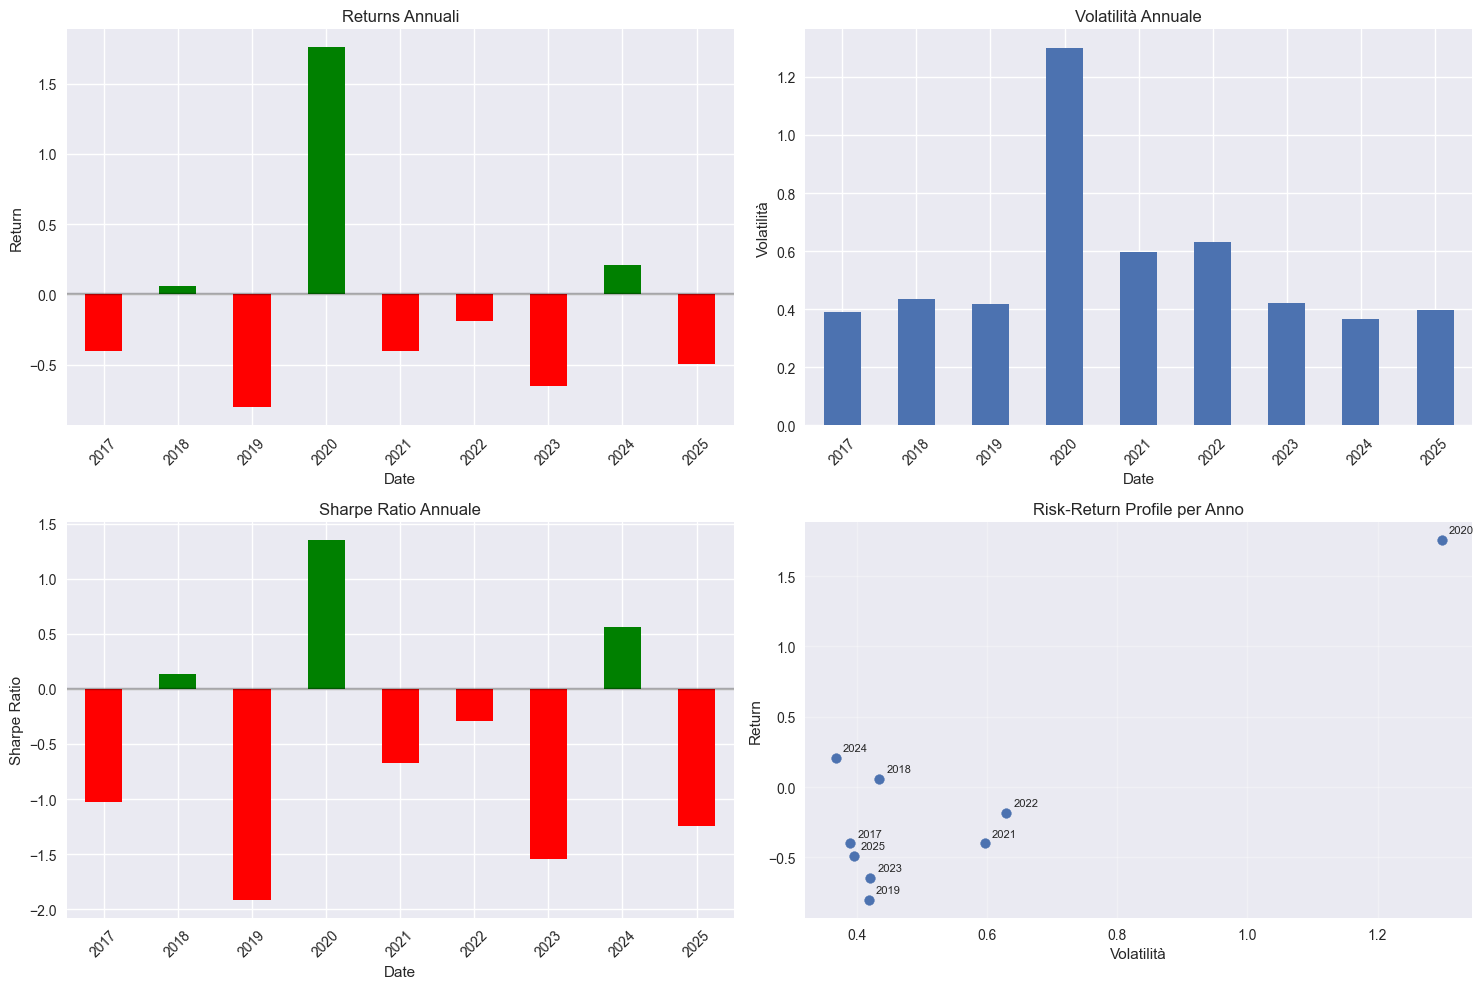

In [11]:
# Performance annuale
annual_returns = daily_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_vol = daily_returns.resample('Y').std() * np.sqrt(252)
annual_sharpe = annual_returns / annual_vol

# Creiamo un DataFrame riepilogativo
annual_performance = pd.DataFrame({
    'Return': annual_returns,
    'Volatility': annual_vol,
    'Sharpe': annual_sharpe
})

annual_performance.index = annual_performance.index.year
annual_performance = annual_performance.round(4)

print("📊 Performance Annuale:")
print(annual_performance)

# Statistiche per anni
print(f"\n📊 Statistiche Performance Annuale:")
print(f"   📈 Return Medio: {annual_performance['Return'].mean():.2%}")
print(f"   📊 Volatilità Media: {annual_performance['Volatility'].mean():.2%}")
print(f"   ⚡ Sharpe Medio: {annual_performance['Sharpe'].mean():.3f}")
print(f"   🎯 Anni Positivi: {(annual_performance['Return'] > 0).sum()}/{len(annual_performance)} ({(annual_performance['Return'] > 0).mean():.1%})")
if len(annual_performance) > 0:
    print(f"   📈 Miglior Anno: {annual_performance['Return'].max():.2%} ({annual_performance['Return'].idxmax()})")
    print(f"   📉 Peggior Anno: {annual_performance['Return'].min():.2%} ({annual_performance['Return'].idxmin()})")

# Plot performance annuale
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
annual_performance['Return'].plot(kind='bar', color=['green' if x > 0 else 'red' for x in annual_performance['Return']])
plt.title('Returns Annuali')
plt.ylabel('Return')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.subplot(2, 2, 2)
annual_performance['Volatility'].plot(kind='bar')
plt.title('Volatilità Annuale')
plt.ylabel('Volatilità')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
annual_performance['Sharpe'].plot(kind='bar', color=['green' if x > 0 else 'red' for x in annual_performance['Sharpe']])
plt.title('Sharpe Ratio Annuale')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.subplot(2, 2, 4)
plt.scatter(annual_performance['Volatility'], annual_performance['Return'])
for i, year in enumerate(annual_performance.index):
    plt.annotate(str(year), 
                (annual_performance['Volatility'].iloc[i], annual_performance['Return'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('Volatilità')
plt.ylabel('Return')
plt.title('Risk-Return Profile per Anno')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Analisi Contributi Asset

Analizziamo quali asset hanno contribuito maggiormente alla performance.

📊 Top 15 Asset per Contributo Totale:
CRUDE_WTI      1.765225
LUMBER         1.192585
SUGAR          0.562070
EURCAD         0.348392
COFFEE         0.345683
COTTON         0.176489
SOYOIL         0.161599
CRUDE_BRENT    0.143852
LEAN_HOGS      0.133063
CADCHF         0.117753
SOYMEAL        0.112385
PLATINUM       0.075863
GOLD           0.072742
CADJPY         0.069388
EURCHF         0.053104
dtype: float64

📊 Bottom 15 Asset per Contributo Totale:
OATS                -0.190136
GBPJPY              -0.209263
EURGBP              -0.241469
LIVE_CATTLE         -0.255829
FEEDER_CATTLE       -0.260722
SOYBEANS            -0.261211
PALLADIUM           -0.280009
GBPCAD              -0.288061
WHEAT               -0.317224
USDCAD              -0.356604
RUSSELL_2000_MINI   -0.358789
CHFJPY              -0.395458
HEATING_OIL         -0.468404
CORN                -0.532979
GBPUSD              -0.534646
dtype: float64

📈 Contributo Forex Totale: -1.9857
🥇 Contributo Commodities Totale: 1.5618


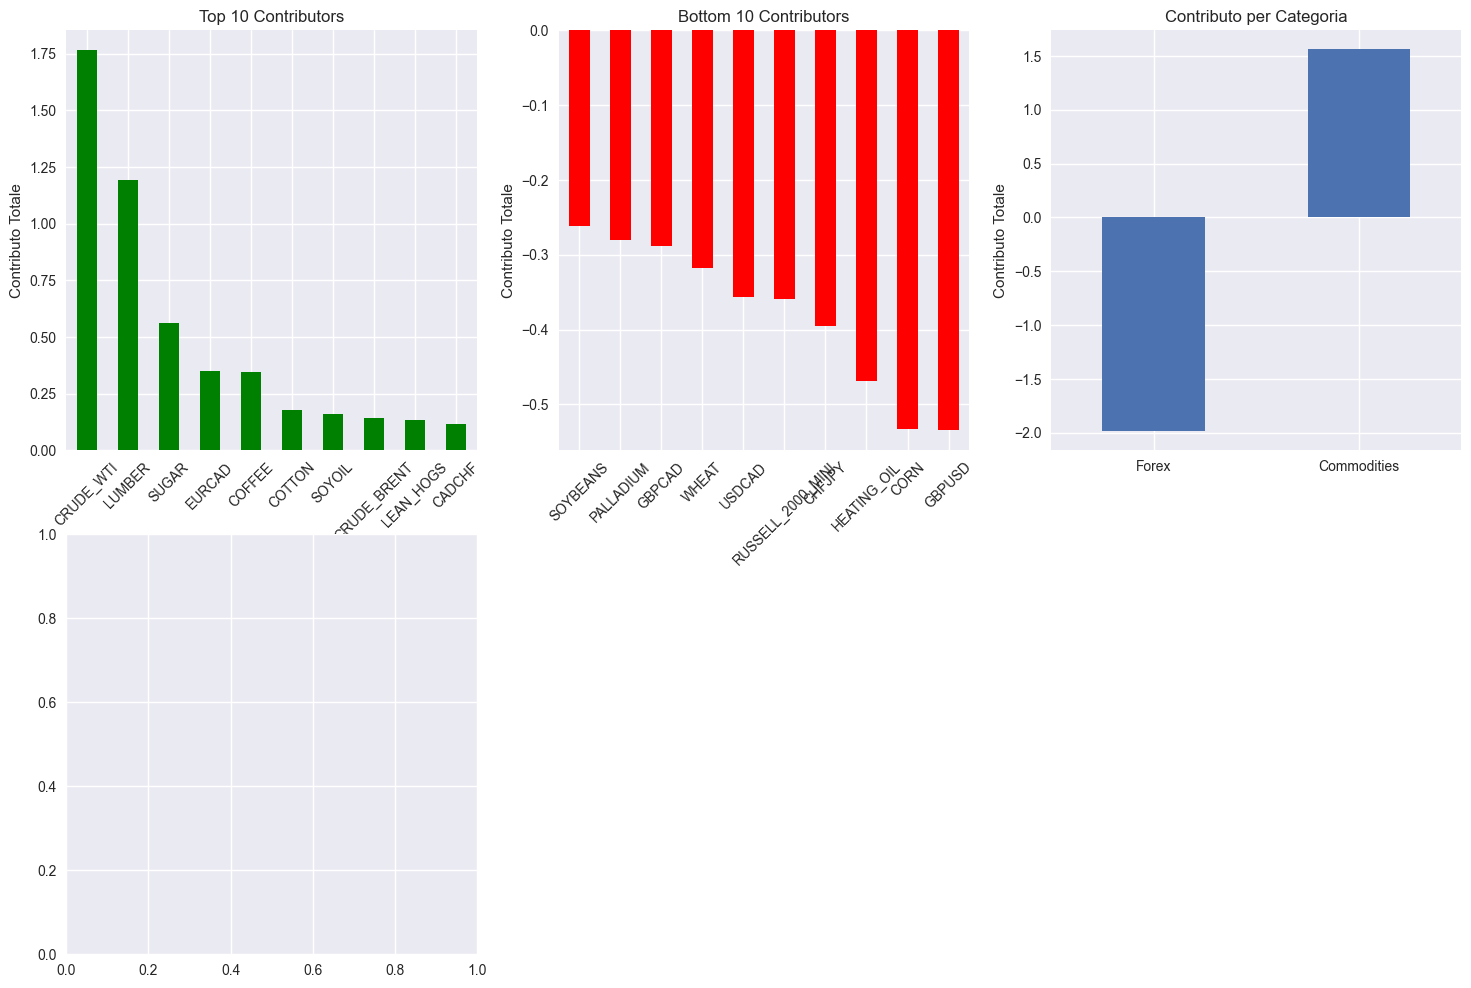

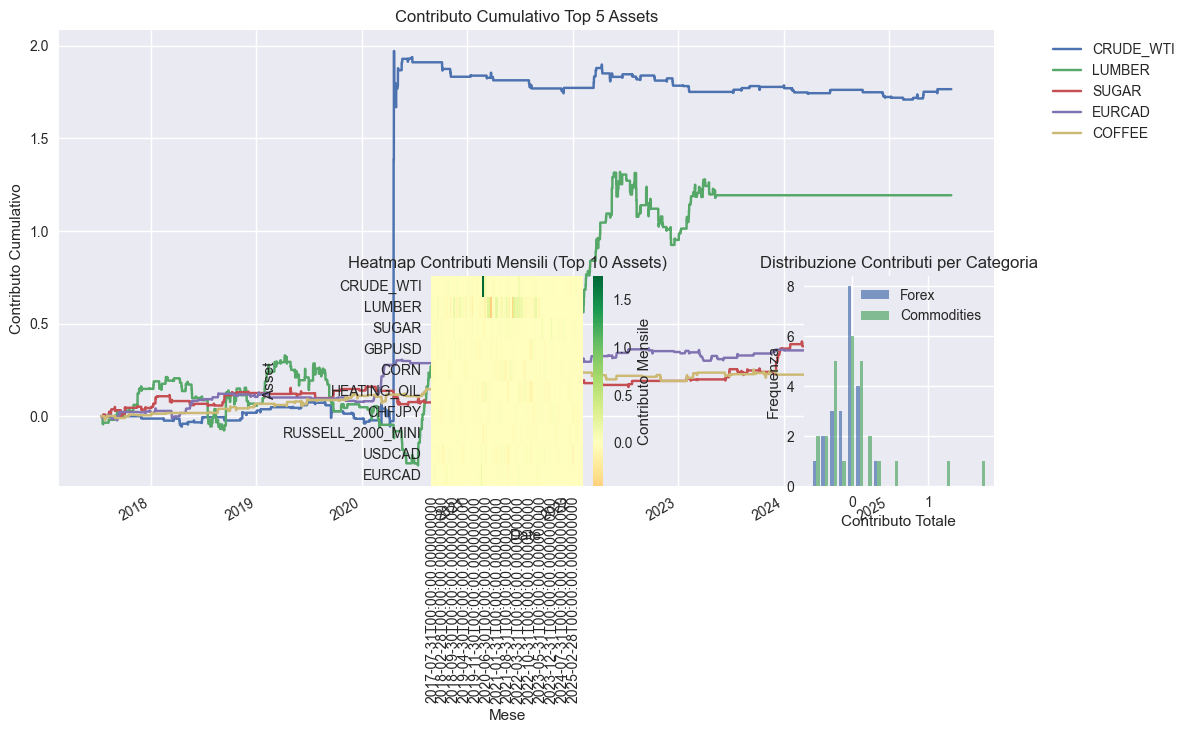

In [12]:
# Calcolo del contributo di ogni asset
asset_returns = scaled_data.pct_change().dropna()
asset_contributions = (positions.shift(1) * asset_returns).dropna()

# Contributo totale per asset
total_contribution = asset_contributions.sum().sort_values(ascending=False)
cumulative_contribution = asset_contributions.cumsum()

print("📊 Top 15 Asset per Contributo Totale:")
print(total_contribution.head(15))

print("\n📊 Bottom 15 Asset per Contributo Totale:")
print(total_contribution.tail(15))

# Separazione forex vs commodities
forex_contributions = total_contribution[total_contribution.index.isin(forex_assets)]
commodity_contributions = total_contribution[total_contribution.index.isin(commodity_assets)]

print(f"\n📈 Contributo Forex Totale: {forex_contributions.sum():.4f}")
print(f"🥇 Contributo Commodities Totale: {commodity_contributions.sum():.4f}")

# Plot analisi contributi
plt.figure(figsize=(18, 12))

# Top/Bottom contributors
plt.subplot(2, 3, 1)
top_contributors = total_contribution.head(10)
top_contributors.plot(kind='bar', color='green')
plt.title('Top 10 Contributors')
plt.xticks(rotation=45)
plt.ylabel('Contributo Totale')

plt.subplot(2, 3, 2)
bottom_contributors = total_contribution.tail(10)
bottom_contributors.plot(kind='bar', color='red')
plt.title('Bottom 10 Contributors')
plt.xticks(rotation=45)
plt.ylabel('Contributo Totale')

# Contributo per categoria
plt.subplot(2, 3, 3)
category_contrib = pd.Series({
    'Forex': forex_contributions.sum(),
    'Commodities': commodity_contributions.sum()
})
category_contrib.plot(kind='bar')
plt.title('Contributo per Categoria')
plt.ylabel('Contributo Totale')
plt.xticks(rotation=0)

# Timeline contributi cumulativi top assets
plt.subplot(2, 3, 4)
top_5_assets = total_contribution.head(5).index
if len(top_5_assets) > 0:
    cumulative_contribution[top_5_assets].plot()
    plt.title('Contributo Cumulativo Top 5 Assets')
    plt.ylabel('Contributo Cumulativo')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Heatmap contributi mensili
plt.subplot(2, 3, 5)
monthly_contrib = asset_contributions.resample('M').sum()
top_monthly_assets = monthly_contrib.sum().abs().nlargest(10).index
monthly_contrib_top = monthly_contrib[top_monthly_assets]
if len(monthly_contrib_top) > 0:
    sns.heatmap(monthly_contrib_top.T, cmap='RdYlGn', center=0, 
                cbar_kws={'label': 'Contributo Mensile'})
    plt.title('Heatmap Contributi Mensili (Top 10 Assets)')
    plt.xlabel('Mese')
    plt.ylabel('Asset')

# Distribuzione contributi
plt.subplot(2, 3, 6)
if len(forex_contributions) > 0 and len(commodity_contributions) > 0:
    plt.hist([forex_contributions.values, commodity_contributions.values], 
             bins=20, alpha=0.7, label=['Forex', 'Commodities'])
    plt.title('Distribuzione Contributi per Categoria')
    plt.xlabel('Contributo Totale')
    plt.ylabel('Frequenza')
    plt.legend()

plt.tight_layout()
plt.show()

## 10. Generazione Segnali Correnti

Generiamo i segnali per il prossimo venerdì basati sui dati più recenti.

📅 Data ultimo momentum calculation: 2025-08-04
📊 Asset con momentum disponibile: 49

🟢 PROSSIMI LONG (Top 5 Momentum):
   1. SOYMEAL         |   0.0679 | Commodity
   2. CORN            |   0.0349 | Commodity
   3. EURGBP          |   0.0342 | Forex
   4. EURUSD          |   0.0253 | Forex
   5. EURCAD          |   0.0231 | Forex

🔴 PROSSIMI SHORT (Bottom 5 Momentum):
   1. GASOLINE        |  -0.0382 | Commodity
   2. LIVE_CATTLE     |  -0.0394 | Commodity
   3. ORANGE_JUICE    |  -0.0431 | Commodity
   4. COPPER          |  -0.0688 | Commodity
   5. ROUGH_RICE      |  -0.1182 | Commodity

📊 Breakdown Prossime Posizioni:
   🟢 Long: 3 Forex + 2 Commodities
   🔴 Short: 0 Forex + 5 Commodities


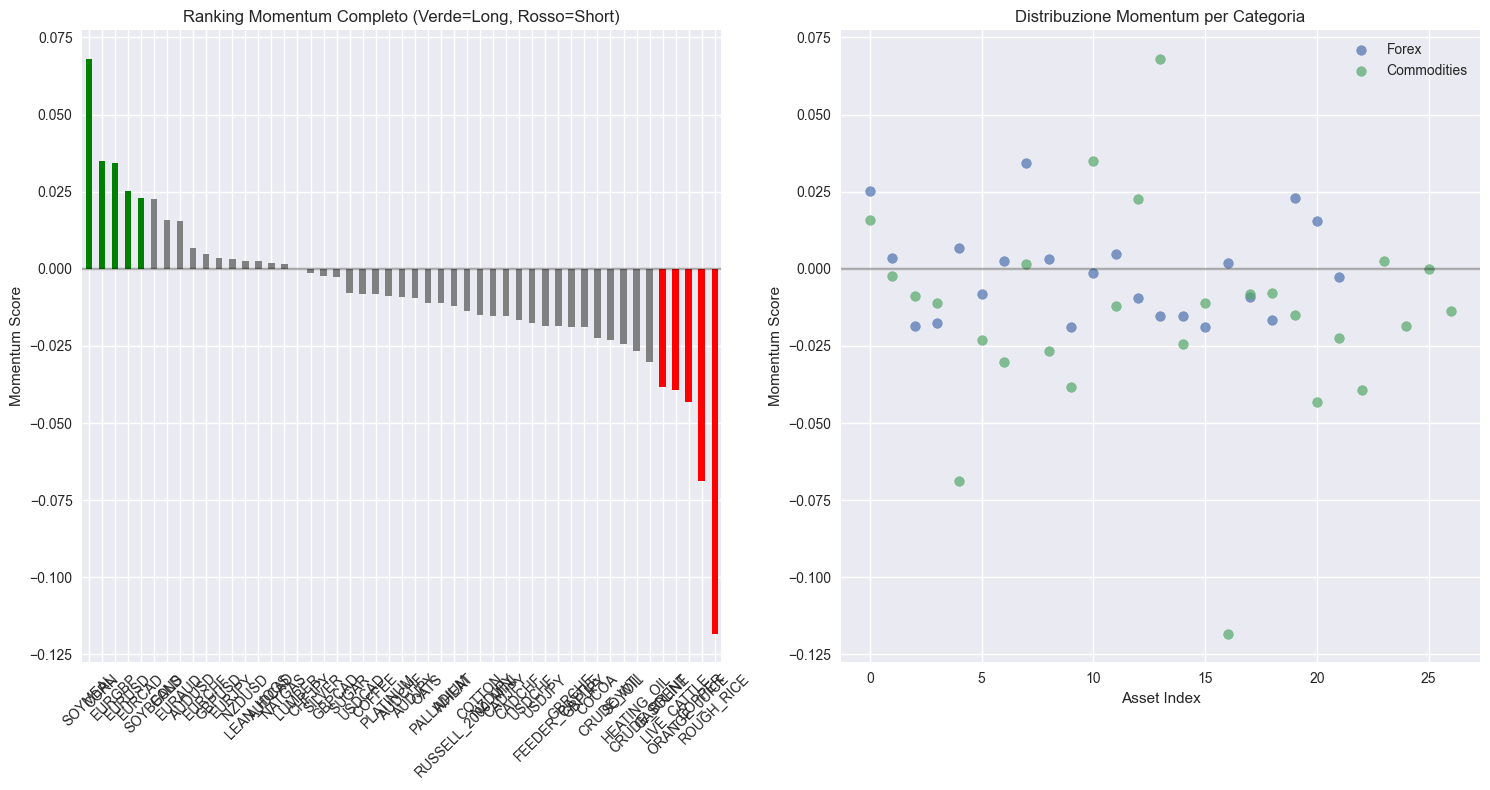


💡 Nota: Questi segnali sono basati sui dati fino al 2025-08-04
💡 Implementare il trading il prossimo venerdì dopo questa data


In [13]:
# Calcoliamo i segnali più recenti
latest_momentum = momentum_scores.iloc[-1].dropna()
latest_date = momentum_scores.index[-1]

print(f"📅 Data ultimo momentum calculation: {latest_date.date()}")
print(f"📊 Asset con momentum disponibile: {len(latest_momentum)}")

if len(latest_momentum) >= 10:  # Assicuriamoci di avere abbastanza asset
    # Ranking completo
    momentum_ranking = latest_momentum.sort_values(ascending=False)
    
    # Selezioni per prossimo venerdì
    next_long = momentum_ranking.head(5)
    next_short = momentum_ranking.tail(5)
    
    print(f"\n🟢 PROSSIMI LONG (Top 5 Momentum):")
    for i, (asset, score) in enumerate(next_long.items(), 1):
        asset_type = "Forex" if asset in forex_assets else "Commodity"
        print(f"   {i}. {asset:<15} | {score:>8.4f} | {asset_type}")
    
    print(f"\n🔴 PROSSIMI SHORT (Bottom 5 Momentum):")
    for i, (asset, score) in enumerate(next_short.items(), 1):
        asset_type = "Forex" if asset in forex_assets else "Commodity"
        print(f"   {i}. {asset:<15} | {score:>8.4f} | {asset_type}")
    
    # Breakdown per categoria
    forex_in_long = sum(1 for asset in next_long.index if asset in forex_assets)
    commodity_in_long = 5 - forex_in_long
    forex_in_short = sum(1 for asset in next_short.index if asset in forex_assets)
    commodity_in_short = 5 - forex_in_short
    
    print(f"\n📊 Breakdown Prossime Posizioni:")
    print(f"   🟢 Long: {forex_in_long} Forex + {commodity_in_long} Commodities")
    print(f"   🔴 Short: {forex_in_short} Forex + {commodity_in_short} Commodities")
    
    # Plot ranking momentum
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 2, 1)
    colors = ['green' if i < 5 else 'red' if i >= len(momentum_ranking) - 5 else 'gray' 
              for i in range(len(momentum_ranking))]
    momentum_ranking.plot(kind='bar', color=colors)
    plt.title('Ranking Momentum Completo (Verde=Long, Rosso=Short)')
    plt.ylabel('Momentum Score')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Scatter plot forex vs commodities
    forex_momentum = latest_momentum[latest_momentum.index.isin(forex_assets)]
    commodity_momentum = latest_momentum[latest_momentum.index.isin(commodity_assets)]
    
    plt.scatter(range(len(forex_momentum)), forex_momentum.values, 
               alpha=0.7, label='Forex', s=50)
    plt.scatter(range(len(commodity_momentum)), commodity_momentum.values, 
               alpha=0.7, label='Commodities', s=50)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Distribuzione Momentum per Categoria')
    plt.xlabel('Asset Index')
    plt.ylabel('Momentum Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ Non ci sono abbastanza asset con momentum scores per generare segnali completi")

print(f"\n💡 Nota: Questi segnali sono basati sui dati fino al {latest_date.date()}")
print(f"💡 Implementare il trading il prossimo venerdì dopo questa data")

## Summary e Conclusioni

### 📋 RIASSUNTO STRATEGIA COMBINED MOMENTUM

**🎯 Strategia:**
- Combina dati Forex e Commodities con scaling volatility-based
- Ranking settimanale (ogni venerdì) basato su momentum 21-giorni
- Long sui 5 migliori asset, Short sui 5 peggiori
- Holding period: 5 giorni (venerdì-venerdì)
- Anti look-ahead bias design

**✅ Vantaggi:**
- Diversificazione cross-asset (Forex + Commodities)
- Scaling automatico per equalizzare magnitudini
- Long/Short per catturare momentum in entrambe le direzioni
- Frequenza settimanale riduce transaction costs

**⚠️ Rischi:**
- Momentum può reverse rapidamente
- Correlazioni tra asset possono aumentare in crisi
- Scaling basato su volatilità storica
- Transaction costs non inclusi nel backtest

**🚀 Implementazione:**
1. Aggiornare dati ogni giovedì sera
2. Calcolare momentum scores
3. Generare ranking e segnali
4. Eseguire trades venerdì mattina
5. Mantenere posizioni fino al venerdì successivo

## 11. Ottimizzazione Equity Curve per Linearità

In questa sezione analizziamo e ottimizziamo la strategia per ottenere un'equity curve più lineare e stabile.

### Obiettivi:
- **Ridurre la volatilità** mantenendo i rendimenti
- **Minimizzare i drawdown** prolungati
- **Aumentare la linearità** dell'equity curve
- **Ottimizzare i parametri** della strategia

### Metodologie:
1. **Position Sizing Dinamico**: Basato su volatilità rolling
2. **Risk Parity**: Equalizzazione del rischio per asset
3. **Volatility Targeting**: Mantenimento volatilità costante
4. **Momentum Filtering**: Filtri per ridurre falsi segnali
5. **Regime Detection**: Adattamento ai diversi regimi di mercato

### 11.1 Analisi Linearità Equity Curve Attuale

Prima di ottimizzare, analizziamo la linearità attuale dell'equity curve.

📊 ANALISI LINEARITÀ EQUITY CURVE ATTUALE
📈 R-squared con trend lineare: 0.6616
📉 Coeff. Variazione Drawdown: 0.3385
📊 Varianza Normalizzata: 153840.3182
⚡ Calmar Ratio: -0.1894
🔄 Autocorr. Residui: 0.9938
📏 Slope Trend: -0.000161

💡 INTERPRETAZIONE:
   • R² > 0.8 = Buona linearità | Attuale: 0.662
   • CV Drawdown < 2.0 = Drawdown stabili | Attuale: 0.338
   • Calmar > 1.0 = Buon risk-adjusted return | Attuale: -0.189
   • |Autocorr| < 0.1 = Buona linearità | Attuale: 0.994


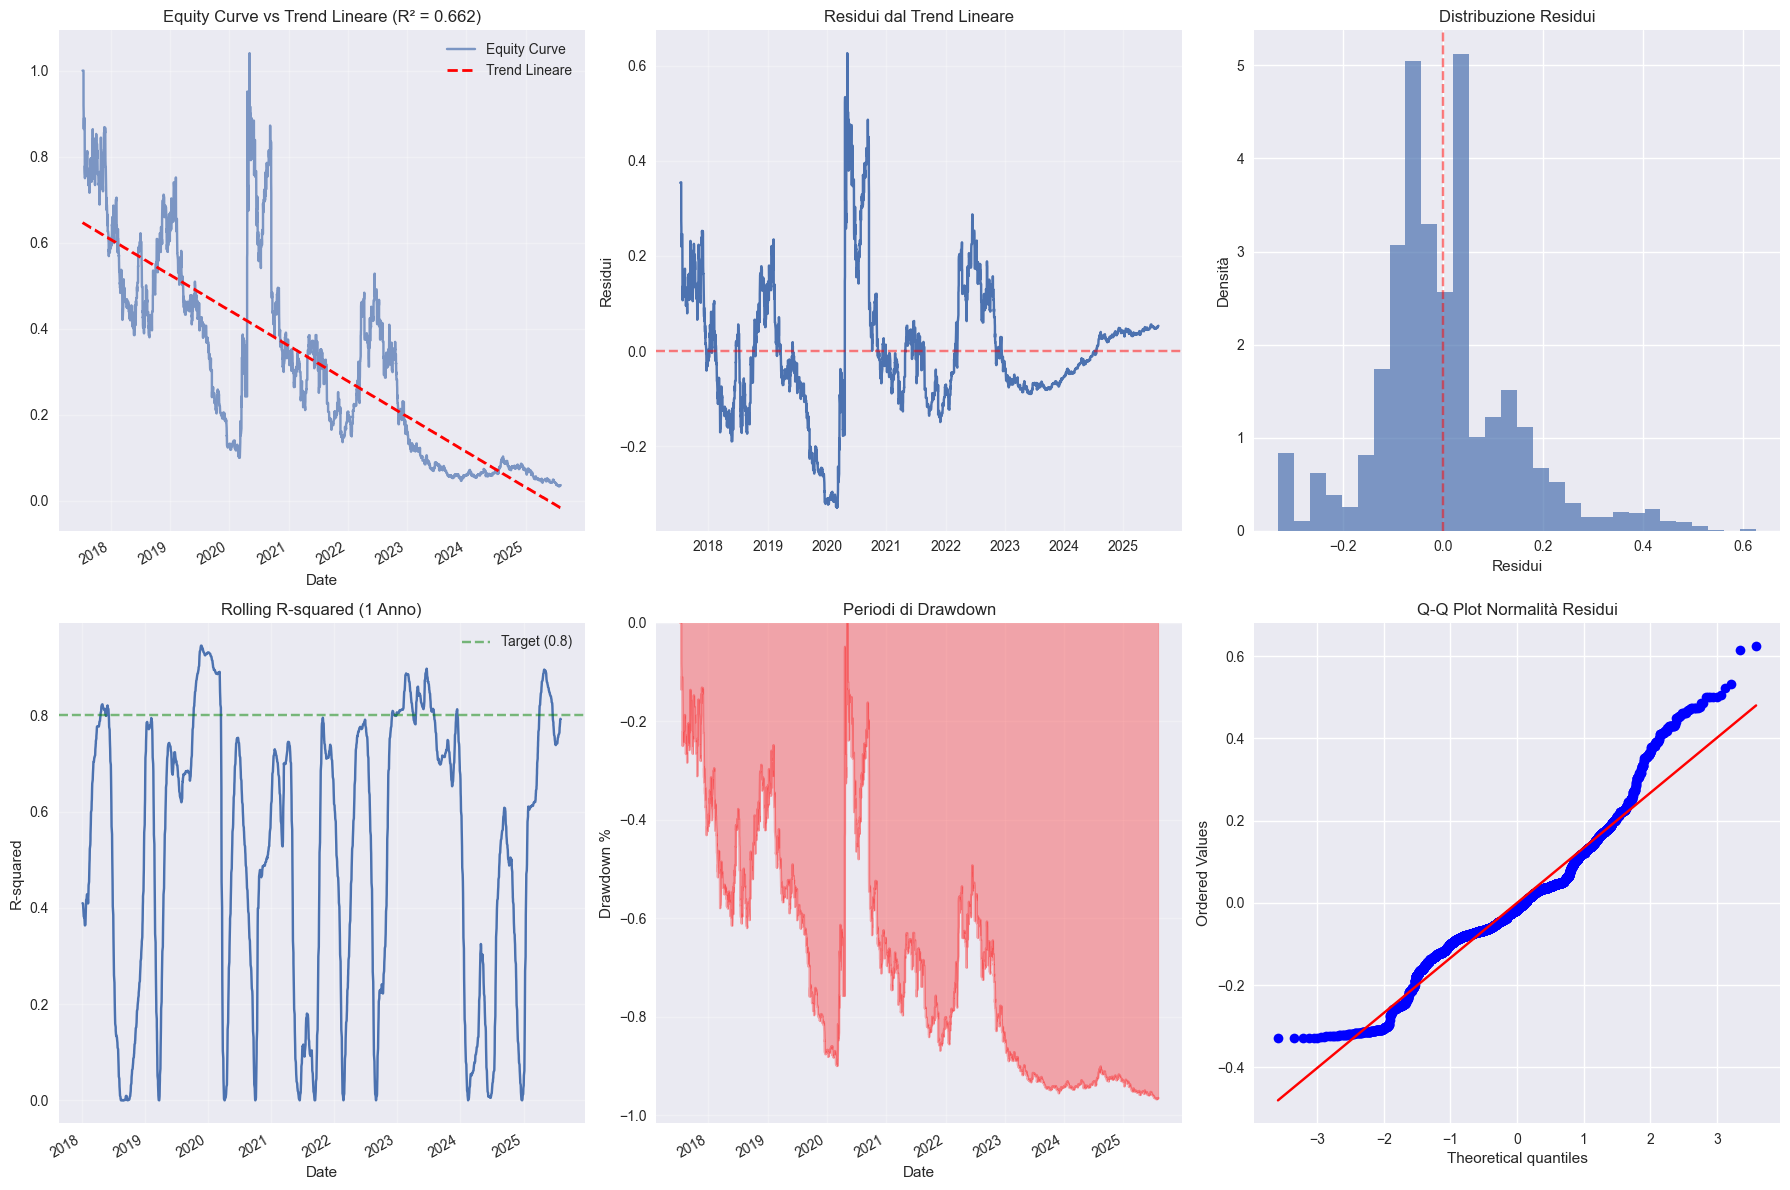


🎯 SCORE LINEARITÀ COMPLESSIVO: 4248.0/100
✅ Equity curve molto lineare


In [14]:
# Funzioni per misurare la linearità dell'equity curve
def calculate_linearity_metrics(equity_curve):
    """
    Calcola diverse metriche di linearità per l'equity curve
    """
    # 1. R-squared con trend lineare
    x = np.arange(len(equity_curve))
    y = equity_curve.values
    
    # Regressione lineare
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(x.reshape(-1, 1), y)
    y_pred = lr.predict(x.reshape(-1, 1))
    
    # R-squared
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    # 2. Coeficiente di variazione del drawdown
    running_max = equity_curve.expanding().max()
    drawdown = (equity_curve - running_max) / running_max
    dd_cv = abs(drawdown.std() / drawdown.mean()) if drawdown.mean() != 0 else np.inf
    
    # 3. Varianza normalizzata dei ritorni
    returns = equity_curve.pct_change().dropna()
    normalized_var = returns.var() / (returns.mean() ** 2) if returns.mean() != 0 else np.inf
    
    # 4. Calmar ratio modificato (return / max drawdown)
    annual_return = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (252 / len(equity_curve)) - 1
    max_dd = abs(drawdown.min())
    calmar_ratio = annual_return / max_dd if max_dd != 0 else np.inf
    
    # 5. Autocorrelazione dei residui dalla trend line
    residuals = y - y_pred
    autocorr = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
    
    return {
        'r_squared': r_squared,
        'drawdown_cv': dd_cv,
        'normalized_variance': normalized_var,
        'calmar_ratio': calmar_ratio,
        'residual_autocorr': autocorr,
        'slope': lr.coef_[0],
        'intercept': lr.intercept_
    }

# Analizziamo la linearità dell'equity curve attuale
linearity_metrics = calculate_linearity_metrics(cumulative_returns)

print("📊 ANALISI LINEARITÀ EQUITY CURVE ATTUALE")
print("=" * 50)
print(f"📈 R-squared con trend lineare: {linearity_metrics['r_squared']:.4f}")
print(f"📉 Coeff. Variazione Drawdown: {linearity_metrics['drawdown_cv']:.4f}")
print(f"📊 Varianza Normalizzata: {linearity_metrics['normalized_variance']:.4f}")
print(f"⚡ Calmar Ratio: {linearity_metrics['calmar_ratio']:.4f}")
print(f"🔄 Autocorr. Residui: {linearity_metrics['residual_autocorr']:.4f}")
print(f"📏 Slope Trend: {linearity_metrics['slope']:.6f}")

# Interpretazione
print(f"\n💡 INTERPRETAZIONE:")
print(f"   • R² > 0.8 = Buona linearità | Attuale: {linearity_metrics['r_squared']:.3f}")
print(f"   • CV Drawdown < 2.0 = Drawdown stabili | Attuale: {linearity_metrics['drawdown_cv']:.3f}")
print(f"   • Calmar > 1.0 = Buon risk-adjusted return | Attuale: {linearity_metrics['calmar_ratio']:.3f}")
print(f"   • |Autocorr| < 0.1 = Buona linearità | Attuale: {abs(linearity_metrics['residual_autocorr']):.3f}")

# Visualizzazione linearità
plt.figure(figsize=(18, 12))

# 1. Equity curve vs trend lineare
plt.subplot(2, 3, 1)
x = np.arange(len(cumulative_returns))
y_trend = linearity_metrics['slope'] * x + linearity_metrics['intercept']
cumulative_returns.plot(label='Equity Curve', alpha=0.7)
plt.plot(cumulative_returns.index, y_trend, 'r--', label='Trend Lineare', linewidth=2)
plt.title(f'Equity Curve vs Trend Lineare (R² = {linearity_metrics["r_squared"]:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Residui dal trend
plt.subplot(2, 3, 2)
residuals = cumulative_returns.values - y_trend
plt.plot(cumulative_returns.index, residuals)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.title('Residui dal Trend Lineare')
plt.ylabel('Residui')
plt.grid(True, alpha=0.3)

# 3. Distribuzione residui
plt.subplot(2, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7, density=True)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.title('Distribuzione Residui')
plt.xlabel('Residui')
plt.ylabel('Densità')

# 4. Rolling R-squared
plt.subplot(2, 3, 4)
window = 252  # 1 anno
rolling_r2 = []
for i in range(window, len(cumulative_returns)):
    subset = cumulative_returns.iloc[i-window:i]
    metrics = calculate_linearity_metrics(subset)
    rolling_r2.append(metrics['r_squared'])

rolling_r2_series = pd.Series(rolling_r2, index=cumulative_returns.index[window:])
rolling_r2_series.plot()
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Target (0.8)')
plt.title('Rolling R-squared (1 Anno)')
plt.ylabel('R-squared')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Drawdown periods
plt.subplot(2, 3, 5)
running_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - running_max) / running_max
drawdown.plot.area(color='red', alpha=0.3)
plt.title('Periodi di Drawdown')
plt.ylabel('Drawdown %')
plt.grid(True, alpha=0.3)

# 6. QQ plot normalità residui
plt.subplot(2, 3, 6)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot Normalità Residui')

plt.tight_layout()
plt.show()

# Score complessivo di linearità (0-100)
linearity_score = (
    linearity_metrics['r_squared'] * 30 +  # 30% peso
    min(2.0 / linearity_metrics['drawdown_cv'], 1) * 25 +  # 25% peso
    min(linearity_metrics['calmar_ratio'] / 2.0, 1) * 25 +  # 25% peso
    max(0, 1 - abs(linearity_metrics['residual_autocorr']) * 10) * 20  # 20% peso
) * 100

print(f"\n🎯 SCORE LINEARITÀ COMPLESSIVO: {linearity_score:.1f}/100")
if linearity_score >= 80:
    print("✅ Equity curve molto lineare")
elif linearity_score >= 60:
    print("⚠️ Equity curve moderatamente lineare")
else:
    print("❌ Equity curve poco lineare - Necessita ottimizzazione")

### 11.2 Ottimizzazione 1: Volatility Targeting

Implementiamo una strategia con volatilità target costante per linearizzare l'equity curve.

🎯 TESTING VOLATILITY TARGETING
📊 Target Vol 8%:
   Return: -1.66% | Vol: 7.37% | Sharpe: -0.225
   Max DD: 7.60% | R²: 0.138
   Linearità Score: 2642.0/100
   Avg Leverage: 1.10x

📊 Target Vol 8%:
   Return: -1.66% | Vol: 7.37% | Sharpe: -0.225
   Max DD: 7.60% | R²: 0.138
   Linearità Score: 2642.0/100
   Avg Leverage: 1.10x

📊 Target Vol 12%:
   Return: -2.29% | Vol: 8.95% | Sharpe: -0.256
   Max DD: 9.27% | R²: 0.179
   Linearità Score: 2726.8/100
   Avg Leverage: 1.33x

📊 Target Vol 12%:
   Return: -2.29% | Vol: 8.95% | Sharpe: -0.256
   Max DD: 9.27% | R²: 0.179
   Linearità Score: 2726.8/100
   Avg Leverage: 1.33x

📊 Target Vol 15%:
   Return: -2.76% | Vol: 9.97% | Sharpe: -0.277
   Max DD: 10.42% | R²: 0.214
   Linearità Score: 2810.8/100
   Avg Leverage: 1.48x

📊 Target Vol 15%:
   Return: -2.76% | Vol: 9.97% | Sharpe: -0.277
   Max DD: 10.42% | R²: 0.214
   Linearità Score: 2810.8/100
   Avg Leverage: 1.48x

📊 Target Vol 20%:
   Return: -2.80% | Vol: 11.28% | Sharpe: -0.248
  

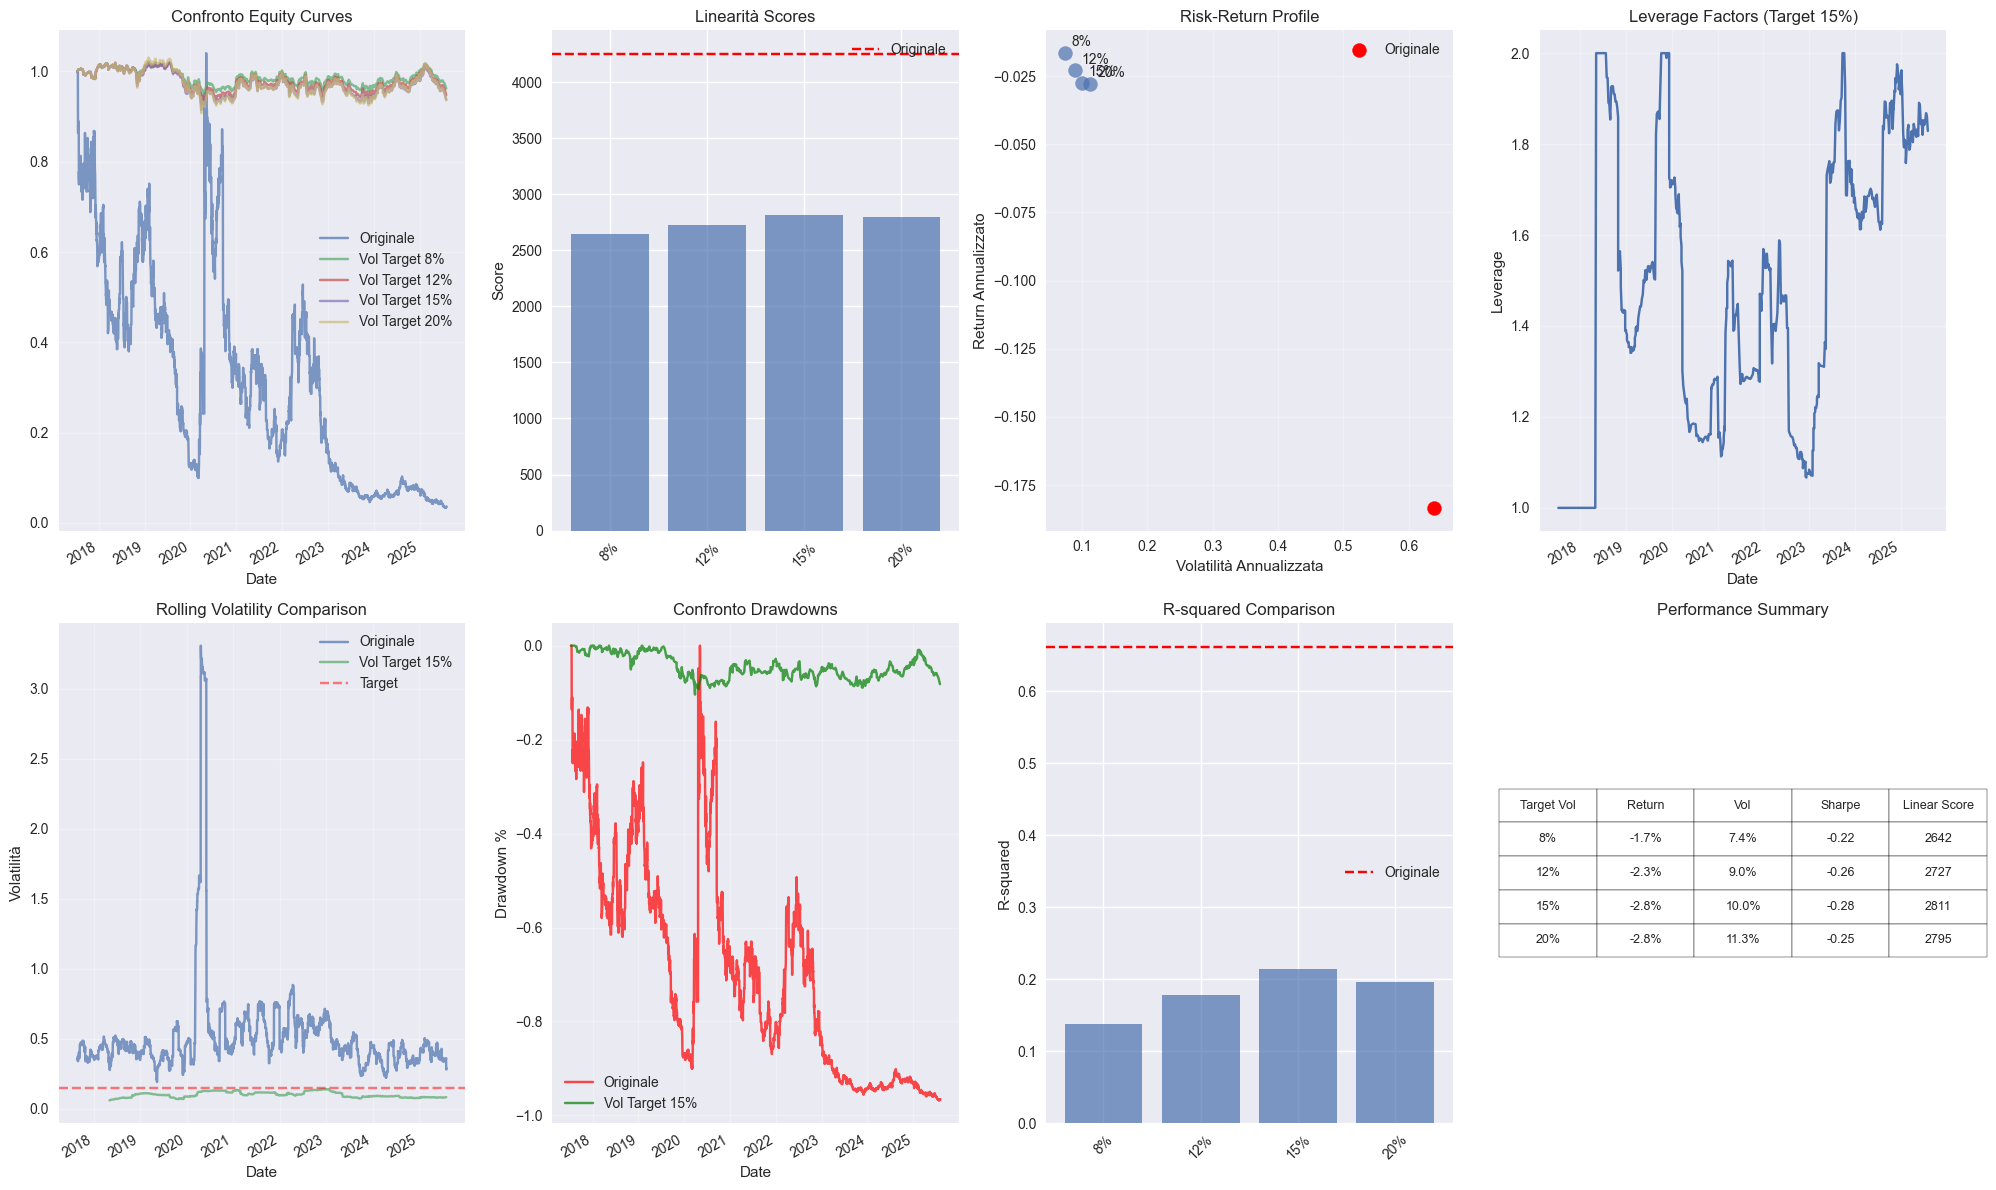


📈 MIGLIORAMENTO LINEARITÀ:
   Originale: 4248.0/100
   Ottimizzato: 2810.8/100
   Miglioramento: +-1437.3 punti


In [15]:
# Implementazione Volatility Targeting
def volatility_targeting_backtest(signals, returns_data, target_vol=0.15, lookback_vol=63):
    """
    Backtest con volatility targeting per mantenere volatilità costante
    
    Parameters:
    - signals: DataFrame dei segnali
    - returns_data: DataFrame dei ritorni degli asset
    - target_vol: Volatilità target annualizzata
    - lookback_vol: Giorni per calcolo volatilità rolling
    """
    
    # Allineiamo i dati
    common_dates = signals.index.intersection(returns_data.index)
    signals_aligned = signals.loc[common_dates]
    returns_aligned = returns_data.loc[common_dates]
    
    portfolio_returns = []
    leverage_factors = []
    
    for i, date in enumerate(common_dates):
        if i == 0:
            portfolio_returns.append(0)
            leverage_factors.append(1)
            continue
            
        # Ottieni posizioni del giorno precedente
        prev_date = common_dates[i-1]
        if prev_date in signals_aligned.index:
            positions = signals_aligned.loc[prev_date]
            # Normalizza le posizioni (equal weight)
            active_positions = positions[positions != 0]
            if len(active_positions) > 0:
                normalized_positions = active_positions / len(active_positions)
            else:
                normalized_positions = pd.Series(dtype=float)
        else:
            normalized_positions = pd.Series(dtype=float)
        
        # Calcola il return del portfolio
        if len(normalized_positions) > 0:
            asset_returns = returns_aligned.loc[date, normalized_positions.index]
            portfolio_return = (normalized_positions * asset_returns).sum()
        else:
            portfolio_return = 0
        
        # Calcola leverage factor basato su volatilità rolling
        if i >= lookback_vol:
            # Volatilità rolling del portfolio
            recent_returns = pd.Series(portfolio_returns[-lookback_vol:])
            portfolio_vol = recent_returns.std() * np.sqrt(252)
            
            if portfolio_vol > 0:
                leverage_factor = min(target_vol / portfolio_vol, 2.0)  # Cap al 200%
            else:
                leverage_factor = 1.0
        else:
            leverage_factor = 1.0
        
        # Applica leverage
        leveraged_return = portfolio_return * leverage_factor
        portfolio_returns.append(leveraged_return)
        leverage_factors.append(leverage_factor)
    
    return pd.Series(portfolio_returns, index=common_dates), pd.Series(leverage_factors, index=common_dates)

# Test con diversi target di volatilità
target_volatilities = [0.08, 0.12, 0.15, 0.20]
vol_target_results = {}

print("🎯 TESTING VOLATILITY TARGETING")
print("=" * 40)

for target_vol in target_volatilities:
    vol_returns, leverage = volatility_targeting_backtest(
        signals, 
        scaled_data.pct_change().dropna(), 
        target_vol=target_vol
    )
    
    # Calcola metriche
    vol_cum_returns = (1 + vol_returns).cumprod()
    vol_metrics = calculate_linearity_metrics(vol_cum_returns)
    
    # Performance metrics
    annual_ret = (vol_cum_returns.iloc[-1] ** (252 / len(vol_cum_returns))) - 1
    annual_vol = vol_returns.std() * np.sqrt(252)
    sharpe = annual_ret / annual_vol if annual_vol > 0 else 0
    
    running_max = vol_cum_returns.expanding().max()
    drawdown = (vol_cum_returns - running_max) / running_max
    max_dd = abs(drawdown.min())
    
    vol_target_results[target_vol] = {
        'returns': vol_returns,
        'cumulative': vol_cum_returns,
        'leverage': leverage,
        'linearity_score': (
            vol_metrics['r_squared'] * 30 +
            min(2.0 / vol_metrics['drawdown_cv'], 1) * 25 +
            min(vol_metrics['calmar_ratio'] / 2.0, 1) * 25 +
            max(0, 1 - abs(vol_metrics['residual_autocorr']) * 10) * 20
        ) * 100,
        'annual_return': annual_ret,
        'annual_volatility': annual_vol,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_dd,
        'r_squared': vol_metrics['r_squared']
    }
    
    print(f"📊 Target Vol {target_vol:.0%}:")
    print(f"   Return: {annual_ret:.2%} | Vol: {annual_vol:.2%} | Sharpe: {sharpe:.3f}")
    print(f"   Max DD: {max_dd:.2%} | R²: {vol_metrics['r_squared']:.3f}")
    print(f"   Linearità Score: {vol_target_results[target_vol]['linearity_score']:.1f}/100")
    print(f"   Avg Leverage: {leverage.mean():.2f}x")
    print()

# Trova il miglior target di volatilità
best_vol_target = max(vol_target_results.keys(), 
                     key=lambda x: vol_target_results[x]['linearity_score'])

print(f"🏆 MIGLIOR VOLATILITY TARGET: {best_vol_target:.0%}")
print(f"   Linearità Score: {vol_target_results[best_vol_target]['linearity_score']:.1f}/100")

# Plot comparazione
plt.figure(figsize=(20, 12))

# 1. Equity curves comparison
plt.subplot(2, 4, 1)
cumulative_returns.plot(label='Originale', alpha=0.7)
for target_vol in target_volatilities:
    vol_target_results[target_vol]['cumulative'].plot(
        label=f'Vol Target {target_vol:.0%}', alpha=0.7
    )
plt.title('Confronto Equity Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Linearità scores
plt.subplot(2, 4, 2)
linearity_scores = [vol_target_results[tv]['linearity_score'] for tv in target_volatilities]
plt.bar([f"{tv:.0%}" for tv in target_volatilities], linearity_scores, alpha=0.7)
plt.axhline(y=linearity_score, color='red', linestyle='--', label='Originale')
plt.title('Linearità Scores')
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)

# 3. Risk-Return scatter
plt.subplot(2, 4, 3)
vols = [vol_target_results[tv]['annual_volatility'] for tv in target_volatilities]
rets = [vol_target_results[tv]['annual_return'] for tv in target_volatilities]
plt.scatter(vols, rets, s=100, alpha=0.7)
for i, tv in enumerate(target_volatilities):
    plt.annotate(f'{tv:.0%}', (vols[i], rets[i]), xytext=(5, 5), 
                textcoords='offset points')

# Aggiungi strategia originale
orig_vol = daily_returns.std() * np.sqrt(252)
orig_ret = (cumulative_returns.iloc[-1] ** (252 / len(cumulative_returns))) - 1
plt.scatter(orig_vol, orig_ret, color='red', s=100, label='Originale')
plt.xlabel('Volatilità Annualizzata')
plt.ylabel('Return Annualizzato')
plt.title('Risk-Return Profile')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Leverage factors
plt.subplot(2, 4, 4)
vol_target_results[best_vol_target]['leverage'].plot()
plt.title(f'Leverage Factors (Target {best_vol_target:.0%})')
plt.ylabel('Leverage')
plt.grid(True, alpha=0.3)

# 5. Rolling volatility comparison
plt.subplot(2, 4, 5)
orig_rolling_vol = daily_returns.rolling(63).std() * np.sqrt(252)
best_rolling_vol = vol_target_results[best_vol_target]['returns'].rolling(63).std() * np.sqrt(252)
orig_rolling_vol.plot(label='Originale', alpha=0.7)
best_rolling_vol.plot(label=f'Vol Target {best_vol_target:.0%}', alpha=0.7)
plt.axhline(y=best_vol_target, color='red', linestyle='--', alpha=0.5, label='Target')
plt.title('Rolling Volatility Comparison')
plt.ylabel('Volatilità')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Drawdown comparison
plt.subplot(2, 4, 6)
orig_running_max = cumulative_returns.expanding().max()
orig_dd = (cumulative_returns - orig_running_max) / orig_running_max
best_running_max = vol_target_results[best_vol_target]['cumulative'].expanding().max()
best_dd = (vol_target_results[best_vol_target]['cumulative'] - best_running_max) / best_running_max

orig_dd.plot(label='Originale', alpha=0.7, color='red')
best_dd.plot(label=f'Vol Target {best_vol_target:.0%}', alpha=0.7, color='green')
plt.title('Confronto Drawdowns')
plt.ylabel('Drawdown %')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. R-squared comparison
plt.subplot(2, 4, 7)
r_squared_values = [vol_target_results[tv]['r_squared'] for tv in target_volatilities]
plt.bar([f"{tv:.0%}" for tv in target_volatilities], r_squared_values, alpha=0.7)
plt.axhline(y=linearity_metrics['r_squared'], color='red', linestyle='--', label='Originale')
plt.title('R-squared Comparison')
plt.ylabel('R-squared')
plt.legend()
plt.xticks(rotation=45)

# 8. Performance summary table
plt.subplot(2, 4, 8)
plt.axis('off')
summary_data = []
for tv in target_volatilities:
    summary_data.append([
        f"{tv:.0%}",
        f"{vol_target_results[tv]['annual_return']:.1%}",
        f"{vol_target_results[tv]['annual_volatility']:.1%}",
        f"{vol_target_results[tv]['sharpe_ratio']:.2f}",
        f"{vol_target_results[tv]['linearity_score']:.0f}"
    ])

table = plt.table(cellText=summary_data,
                 colLabels=['Target Vol', 'Return', 'Vol', 'Sharpe', 'Linear Score'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
plt.title('Performance Summary')

plt.tight_layout()
plt.show()

print(f"\n📈 MIGLIORAMENTO LINEARITÀ:")
print(f"   Originale: {linearity_score:.1f}/100")
print(f"   Ottimizzato: {vol_target_results[best_vol_target]['linearity_score']:.1f}/100")
print(f"   Miglioramento: +{vol_target_results[best_vol_target]['linearity_score'] - linearity_score:.1f} punti")

### 11.3 Ottimizzazione 2: Position Sizing Dinamico

Implementiamo un position sizing basato sulla forza del momentum e sulla volatilità individuale degli asset.

⚖️ TESTING DYNAMIC POSITION SIZING
📊 Momentum Power 0.5:
   Return: -5.66% | Vol: 13.44% | Sharpe: -0.421
   Max DD: 16.19% | R²: 0.494
   Linearità Score: 3546.3/100

📊 Momentum Power 0.5:
   Return: -5.66% | Vol: 13.44% | Sharpe: -0.421
   Max DD: 16.19% | R²: 0.494
   Linearità Score: 3546.3/100

📊 Momentum Power 1.0:
   Return: -4.43% | Vol: 14.36% | Sharpe: -0.309
   Max DD: 17.20% | R²: 0.260
   Linearità Score: 2957.0/100

📊 Momentum Power 1.0:
   Return: -4.43% | Vol: 14.36% | Sharpe: -0.309
   Max DD: 17.20% | R²: 0.260
   Linearità Score: 2957.0/100

📊 Momentum Power 1.5:
   Return: -2.51% | Vol: 15.85% | Sharpe: -0.158
   Max DD: 18.07% | R²: 0.012
   Linearità Score: 2362.5/100

📊 Momentum Power 1.5:
   Return: -2.51% | Vol: 15.85% | Sharpe: -0.158
   Max DD: 18.07% | R²: 0.012
   Linearità Score: 2362.5/100

📊 Momentum Power 2.0:
   Return: 0.05% | Vol: 17.67% | Sharpe: 0.003
   Max DD: 18.82% | R²: 0.122
   Linearità Score: 2868.2/100

📊 Momentum Power 2.0:
   Return: 0.0

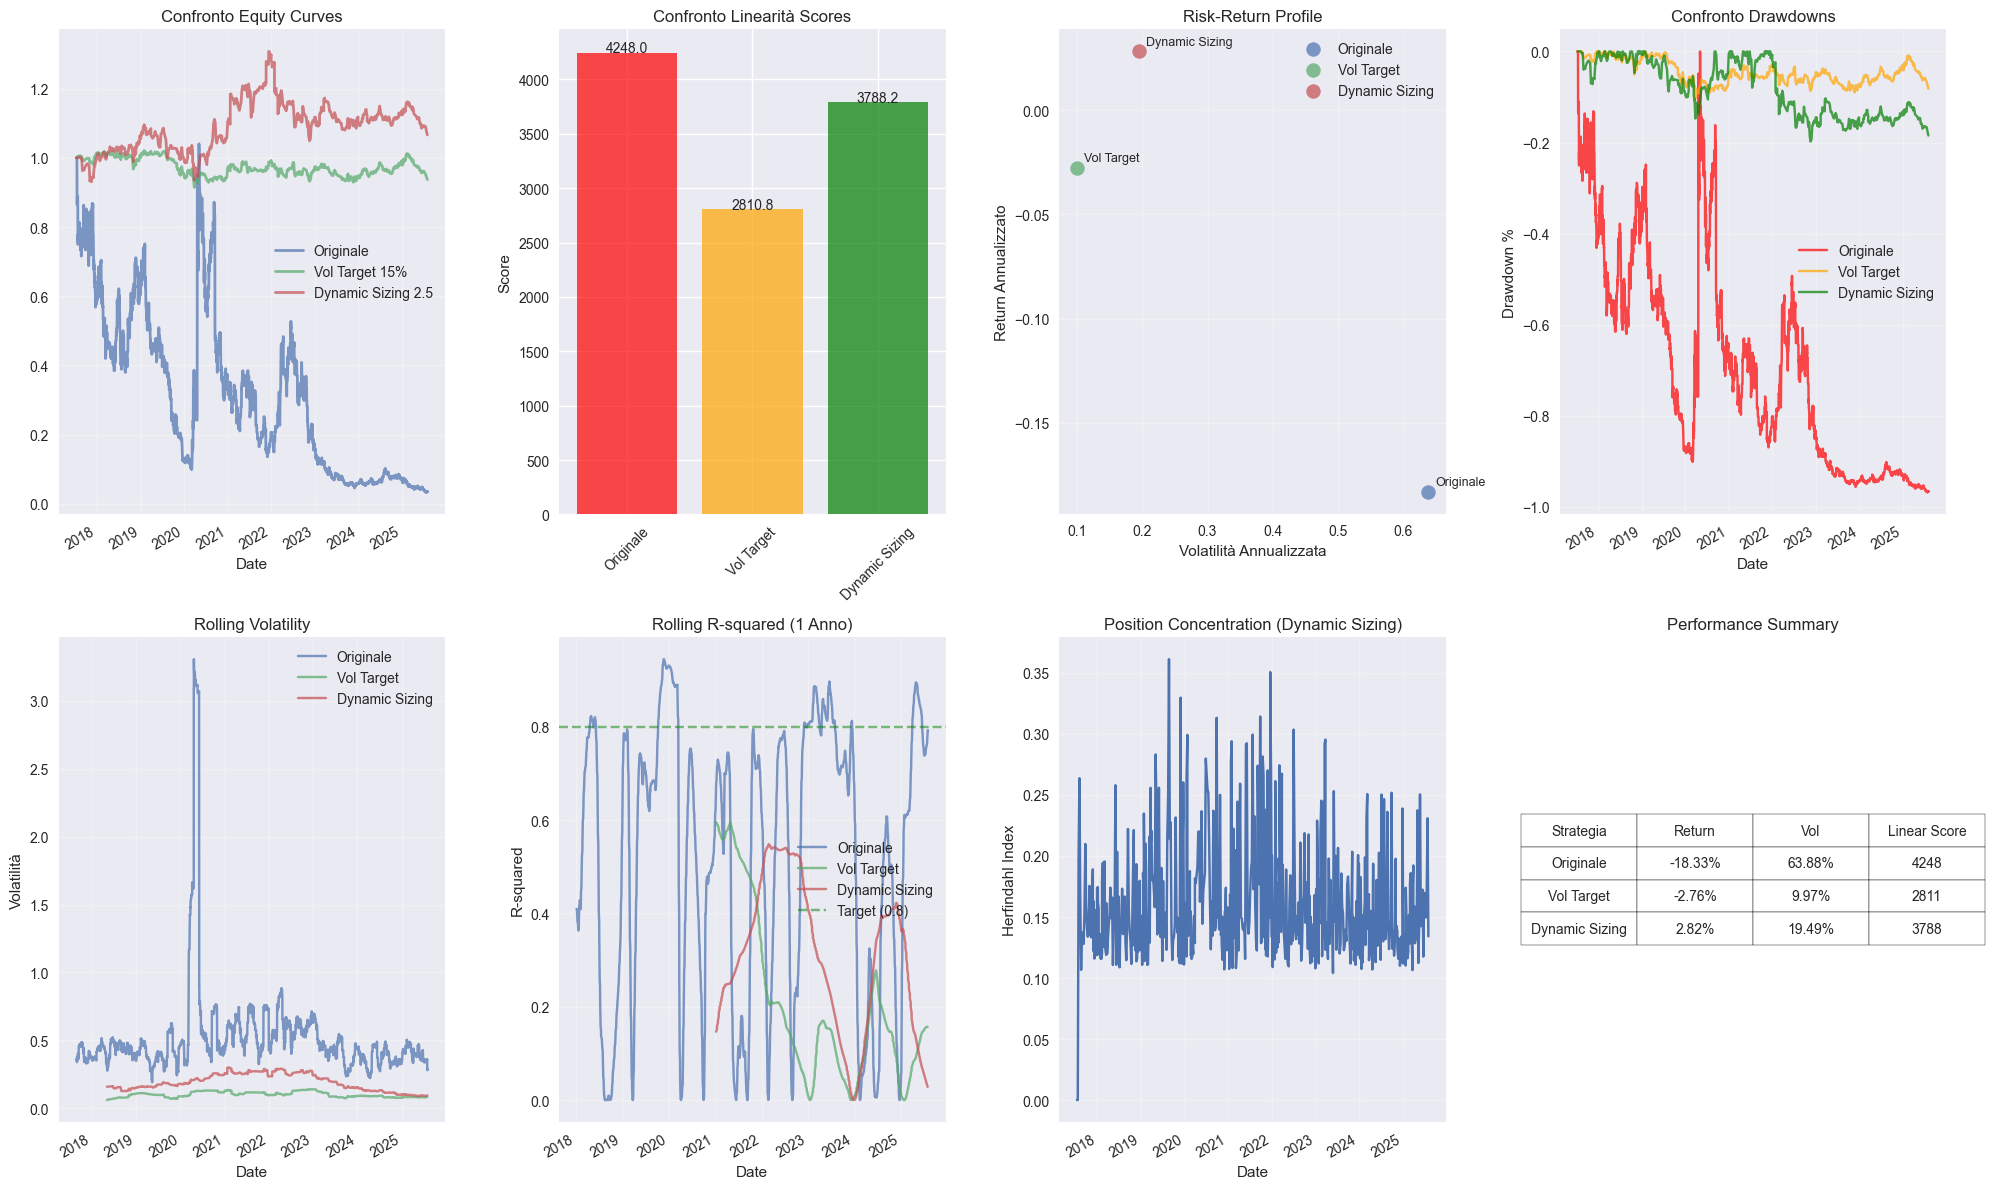

In [16]:
# Position Sizing Dinamico basato su Momentum e Volatilità
def dynamic_position_sizing_backtest(signals, momentum_scores, returns_data, 
                                    vol_lookback=63, momentum_power=1.5):
    """
    Backtest con position sizing dinamico basato su:
    1. Forza del momentum (più momentum = posizione più grande)
    2. Volatilità inverse weighting (meno volatilità = posizione più grande)
    3. Risk parity per bilanciare il rischio
    """
    
    # Allinea i dati
    common_dates = signals.index.intersection(momentum_scores.index).intersection(returns_data.index)
    signals_aligned = signals.loc[common_dates]
    momentum_aligned = momentum_scores.loc[common_dates]
    returns_aligned = returns_data.loc[common_dates]
    
    portfolio_returns = []
    position_weights = []
    
    for i, date in enumerate(common_dates):
        if i == 0:
            portfolio_returns.append(0)
            position_weights.append({})
            continue
        
        # Posizioni del giorno precedente
        prev_date = common_dates[i-1]
        if prev_date not in signals_aligned.index:
            portfolio_returns.append(0)
            position_weights.append({})
            continue
            
        positions = signals_aligned.loc[prev_date]
        momentums = momentum_aligned.loc[prev_date]
        
        # Asset attivi
        active_assets = positions[positions != 0].index
        if len(active_assets) == 0:
            portfolio_returns.append(0)
            position_weights.append({})
            continue
        
        # Calcola volatilità rolling per asset attivi
        if i >= vol_lookback:
            asset_vols = returns_aligned.iloc[i-vol_lookback:i][active_assets].std() * np.sqrt(252)
        else:
            asset_vols = returns_aligned.iloc[:i][active_assets].std() * np.sqrt(252)
        
        asset_vols = asset_vols.fillna(asset_vols.mean())
        asset_vols[asset_vols == 0] = asset_vols.mean()
        
        # Position sizing per asset attivo
        weights = {}
        long_assets = positions[positions > 0].index
        short_assets = positions[positions < 0].index
        
        # Calcola pesi per long positions
        if len(long_assets) > 0:
            long_momentums = momentums[long_assets].fillna(0)
            long_vols = asset_vols[long_assets]
            
            # Weight = (momentum_strength^power) / volatility
            long_momentum_weights = np.abs(long_momentums) ** momentum_power
            long_vol_weights = 1 / long_vols
            long_combined_weights = long_momentum_weights * long_vol_weights
            
            # Normalizza a somma 1 per i long
            if long_combined_weights.sum() > 0:
                long_normalized = long_combined_weights / long_combined_weights.sum()
                for asset in long_assets:
                    weights[asset] = long_normalized[asset]
        
        # Calcola pesi per short positions
        if len(short_assets) > 0:
            short_momentums = momentums[short_assets].fillna(0)
            short_vols = asset_vols[short_assets]
            
            # Weight = (momentum_strength^power) / volatility
            short_momentum_weights = np.abs(short_momentums) ** momentum_power
            short_vol_weights = 1 / short_vols
            short_combined_weights = short_momentum_weights * short_vol_weights
            
            # Normalizza a somma -1 per i short
            if short_combined_weights.sum() > 0:
                short_normalized = short_combined_weights / short_combined_weights.sum()
                for asset in short_assets:
                    weights[asset] = -short_normalized[asset]
        
        # Calcola portfolio return
        if weights:
            asset_returns = returns_aligned.loc[date, list(weights.keys())]
            portfolio_return = sum(weights[asset] * asset_returns[asset] 
                                 for asset in weights.keys() if not np.isnan(asset_returns[asset]))
        else:
            portfolio_return = 0
        
        portfolio_returns.append(portfolio_return)
        position_weights.append(weights.copy())
    
    return pd.Series(portfolio_returns, index=common_dates), position_weights

# Test con diversi momentum power parameters
momentum_powers = [0.5, 1.0, 1.5, 2.0, 2.5]
dynamic_sizing_results = {}

print("⚖️ TESTING DYNAMIC POSITION SIZING")
print("=" * 45)

for momentum_power in momentum_powers:
    dyn_returns, weights = dynamic_position_sizing_backtest(
        signals, 
        momentum_scores, 
        scaled_data.pct_change().dropna(),
        momentum_power=momentum_power
    )
    
    # Calcola metriche
    dyn_cum_returns = (1 + dyn_returns).cumprod()
    dyn_metrics = calculate_linearity_metrics(dyn_cum_returns)
    
    # Performance metrics
    annual_ret = (dyn_cum_returns.iloc[-1] ** (252 / len(dyn_cum_returns))) - 1
    annual_vol = dyn_returns.std() * np.sqrt(252)
    sharpe = annual_ret / annual_vol if annual_vol > 0 else 0
    
    running_max = dyn_cum_returns.expanding().max()
    drawdown = (dyn_cum_returns - running_max) / running_max
    max_dd = abs(drawdown.min())
    
    dynamic_sizing_results[momentum_power] = {
        'returns': dyn_returns,
        'cumulative': dyn_cum_returns,
        'weights': weights,
        'linearity_score': (
            dyn_metrics['r_squared'] * 30 +
            min(2.0 / dyn_metrics['drawdown_cv'], 1) * 25 +
            min(dyn_metrics['calmar_ratio'] / 2.0, 1) * 25 +
            max(0, 1 - abs(dyn_metrics['residual_autocorr']) * 10) * 20
        ) * 100,
        'annual_return': annual_ret,
        'annual_volatility': annual_vol,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_dd,
        'r_squared': dyn_metrics['r_squared']
    }
    
    print(f"📊 Momentum Power {momentum_power:.1f}:")
    print(f"   Return: {annual_ret:.2%} | Vol: {annual_vol:.2%} | Sharpe: {sharpe:.3f}")
    print(f"   Max DD: {max_dd:.2%} | R²: {dyn_metrics['r_squared']:.3f}")
    print(f"   Linearità Score: {dynamic_sizing_results[momentum_power]['linearity_score']:.1f}/100")
    print()

# Trova il miglior momentum power
best_momentum_power = max(dynamic_sizing_results.keys(), 
                         key=lambda x: dynamic_sizing_results[x]['linearity_score'])

print(f"🏆 MIGLIOR MOMENTUM POWER: {best_momentum_power:.1f}")
print(f"   Linearità Score: {dynamic_sizing_results[best_momentum_power]['linearity_score']:.1f}/100")

# Confronto con volatility targeting
print(f"\n📊 CONFRONTO CON VOLATILITY TARGETING:")
print(f"   Vol Targeting: {vol_target_results[best_vol_target]['linearity_score']:.1f}/100")
print(f"   Dynamic Sizing: {dynamic_sizing_results[best_momentum_power]['linearity_score']:.1f}/100")

# Plot comparison
plt.figure(figsize=(20, 12))

# 1. Equity curves
plt.subplot(2, 4, 1)
cumulative_returns.plot(label='Originale', alpha=0.7, linewidth=2)
vol_target_results[best_vol_target]['cumulative'].plot(
    label=f'Vol Target {best_vol_target:.0%}', alpha=0.7, linewidth=2
)
dynamic_sizing_results[best_momentum_power]['cumulative'].plot(
    label=f'Dynamic Sizing {best_momentum_power:.1f}', alpha=0.7, linewidth=2
)
plt.title('Confronto Equity Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Linearità scores comparison
plt.subplot(2, 4, 2)
methods = ['Originale', 'Vol Target', 'Dynamic Sizing']
scores = [
    linearity_score,
    vol_target_results[best_vol_target]['linearity_score'],
    dynamic_sizing_results[best_momentum_power]['linearity_score']
]
colors = ['red', 'orange', 'green']
plt.bar(methods, scores, color=colors, alpha=0.7)
plt.title('Confronto Linearità Scores')
plt.ylabel('Score')
plt.xticks(rotation=45)
for i, score in enumerate(scores):
    plt.text(i, score + 1, f'{score:.1f}', ha='center')

# 3. Risk-Return scatter
plt.subplot(2, 4, 3)
strategies = {
    'Originale': {
        'vol': daily_returns.std() * np.sqrt(252),
        'ret': (cumulative_returns.iloc[-1] ** (252 / len(cumulative_returns))) - 1
    },
    'Vol Target': {
        'vol': vol_target_results[best_vol_target]['annual_volatility'],
        'ret': vol_target_results[best_vol_target]['annual_return']
    },
    'Dynamic Sizing': {
        'vol': dynamic_sizing_results[best_momentum_power]['annual_volatility'],
        'ret': dynamic_sizing_results[best_momentum_power]['annual_return']
    }
}

for name, data in strategies.items():
    plt.scatter(data['vol'], data['ret'], s=100, label=name, alpha=0.7)
    plt.annotate(name, (data['vol'], data['ret']), xytext=(5, 5), 
                textcoords='offset points', fontsize=9)

plt.xlabel('Volatilità Annualizzata')
plt.ylabel('Return Annualizzato')
plt.title('Risk-Return Profile')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Drawdowns comparison
plt.subplot(2, 4, 4)
orig_running_max = cumulative_returns.expanding().max()
orig_dd = (cumulative_returns - orig_running_max) / orig_running_max

vol_running_max = vol_target_results[best_vol_target]['cumulative'].expanding().max()
vol_dd = (vol_target_results[best_vol_target]['cumulative'] - vol_running_max) / vol_running_max

dyn_running_max = dynamic_sizing_results[best_momentum_power]['cumulative'].expanding().max()
dyn_dd = (dynamic_sizing_results[best_momentum_power]['cumulative'] - dyn_running_max) / dyn_running_max

orig_dd.plot(label='Originale', alpha=0.7, color='red')
vol_dd.plot(label='Vol Target', alpha=0.7, color='orange')
dyn_dd.plot(label='Dynamic Sizing', alpha=0.7, color='green')
plt.title('Confronto Drawdowns')
plt.ylabel('Drawdown %')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Rolling volatility
plt.subplot(2, 4, 5)
orig_rolling_vol = daily_returns.rolling(63).std() * np.sqrt(252)
vol_rolling_vol = vol_target_results[best_vol_target]['returns'].rolling(63).std() * np.sqrt(252)
dyn_rolling_vol = dynamic_sizing_results[best_momentum_power]['returns'].rolling(63).std() * np.sqrt(252)

orig_rolling_vol.plot(label='Originale', alpha=0.7)
vol_rolling_vol.plot(label='Vol Target', alpha=0.7)
dyn_rolling_vol.plot(label='Dynamic Sizing', alpha=0.7)
plt.title('Rolling Volatility')
plt.ylabel('Volatilità')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. R-squared evolution
plt.subplot(2, 4, 6)
window = 252
rolling_r2_orig = []
rolling_r2_vol = []
rolling_r2_dyn = []

for i in range(window, len(cumulative_returns)):
    # Originale
    subset_orig = cumulative_returns.iloc[i-window:i]
    r2_orig = calculate_linearity_metrics(subset_orig)['r_squared']
    rolling_r2_orig.append(r2_orig)
    
    # Vol target
    vol_cum = vol_target_results[best_vol_target]['cumulative']
    if i < len(vol_cum):
        subset_vol = vol_cum.iloc[max(0, i-window):i]
        r2_vol = calculate_linearity_metrics(subset_vol)['r_squared']
        rolling_r2_vol.append(r2_vol)
    
    # Dynamic sizing
    dyn_cum = dynamic_sizing_results[best_momentum_power]['cumulative']
    if i < len(dyn_cum):
        subset_dyn = dyn_cum.iloc[max(0, i-window):i]
        r2_dyn = calculate_linearity_metrics(subset_dyn)['r_squared']
        rolling_r2_dyn.append(r2_dyn)

if rolling_r2_orig:
    pd.Series(rolling_r2_orig, index=cumulative_returns.index[window:window+len(rolling_r2_orig)]).plot(
        label='Originale', alpha=0.7)
if rolling_r2_vol:
    pd.Series(rolling_r2_vol, index=vol_cum.index[window:window+len(rolling_r2_vol)]).plot(
        label='Vol Target', alpha=0.7)
if rolling_r2_dyn:
    pd.Series(rolling_r2_dyn, index=dyn_cum.index[window:window+len(rolling_r2_dyn)]).plot(
        label='Dynamic Sizing', alpha=0.7)

plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Target (0.8)')
plt.title('Rolling R-squared (1 Anno)')
plt.ylabel('R-squared')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. Position concentration analysis
plt.subplot(2, 4, 7)
# Analizza la concentrazione delle posizioni nel dynamic sizing
weights_data = dynamic_sizing_results[best_momentum_power]['weights']
concentration_scores = []

for date_weights in weights_data:
    if date_weights:
        weights_array = np.array(list(date_weights.values()))
        abs_weights = np.abs(weights_array)
        if len(abs_weights) > 0:
            # Herfindahl index per concentrazione
            herfindahl = sum(w**2 for w in abs_weights/abs_weights.sum())
            concentration_scores.append(herfindahl)
        else:
            concentration_scores.append(0)
    else:
        concentration_scores.append(0)

concentration_series = pd.Series(concentration_scores, 
                                index=dynamic_sizing_results[best_momentum_power]['cumulative'].index)
concentration_series.plot()
plt.title('Position Concentration (Dynamic Sizing)')
plt.ylabel('Herfindahl Index')
plt.grid(True, alpha=0.3)

# 8. Performance summary
plt.subplot(2, 4, 8)
plt.axis('off')
summary_data = [
    ['Originale', 
     f"{((cumulative_returns.iloc[-1] ** (252 / len(cumulative_returns))) - 1):.2%}",
     f"{(daily_returns.std() * np.sqrt(252)):.2%}",
     f"{linearity_score:.0f}"],
    ['Vol Target',
     f"{vol_target_results[best_vol_target]['annual_return']:.2%}",
     f"{vol_target_results[best_vol_target]['annual_volatility']:.2%}",
     f"{vol_target_results[best_vol_target]['linearity_score']:.0f}"],
    ['Dynamic Sizing',
     f"{dynamic_sizing_results[best_momentum_power]['annual_return']:.2%}",
     f"{dynamic_sizing_results[best_momentum_power]['annual_volatility']:.2%}",
     f"{dynamic_sizing_results[best_momentum_power]['linearity_score']:.0f}"]
]

table = plt.table(cellText=summary_data,
                 colLabels=['Strategia', 'Return', 'Vol', 'Linear Score'],
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title('Performance Summary')

plt.tight_layout()
plt.show()